In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\


C:\Users\User\AppData\Local\Temp\ipykernel_103552\986024606.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17                  7.66               5.43   
647     8000         13.58  1015.12                  8.11               5.32   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-05 03:48:24,925] A new study created in memory with name: no-name-8f7a6342-b7cd-47c5-a6c9-0567297c1b74
[I 2025-06-05 03:51:36,995] Trial 0 finished with value: 32.91527404785156 and parameters: {'lr': 0.40313837924398066, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4821901449436429}. Best is trial 0 with value: 32.91527404785156.


Cross Validation Accuracies:
[34.745506286621094, 32.51778030395508, 32.0853271484375, 20.66826629638672, 44.55949020385742]
Mean Cross Validation Accuracy:
32.91527404785156
Standard Deviation of Cross Validation Accuracy:
7.6127988536719275


[I 2025-06-05 03:54:44,047] Trial 1 finished with value: 2.1821972608566282 and parameters: {'lr': 0.33713867001575637, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2774175578708129}. Best is trial 1 with value: 2.1821972608566282.


Cross Validation Accuracies:
[2.628894329071045, 2.4735372066497803, 2.878995656967163, 1.1849006414413452, 1.7446584701538086]
Mean Cross Validation Accuracy:
2.1821972608566282
Standard Deviation of Cross Validation Accuracy:
0.6254575892984533


[I 2025-06-05 03:57:44,163] Trial 2 finished with value: 0.09392099827528 and parameters: {'lr': 0.1438139960850077, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2453115923668966}. Best is trial 2 with value: 0.09392099827528.


Cross Validation Accuracies:
[0.1165856346487999, 0.09796267002820969, 0.07538372278213501, 0.10839086771011353, 0.07128209620714188]
Mean Cross Validation Accuracy:
0.09392099827528
Standard Deviation of Cross Validation Accuracy:
0.01786364152978302


[I 2025-06-05 03:59:44,634] Trial 3 finished with value: 0.12666760385036469 and parameters: {'lr': 0.0047274068081208254, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.462716508414591}. Best is trial 2 with value: 0.09392099827528.


Cross Validation Accuracies:
[0.13379546999931335, 0.10961034893989563, 0.11839091777801514, 0.14033906161785126, 0.13120222091674805]
Mean Cross Validation Accuracy:
0.12666760385036469
Standard Deviation of Cross Validation Accuracy:
0.011115137990013244


[I 2025-06-05 04:01:49,408] Trial 4 finished with value: 0.5106537044048309 and parameters: {'lr': 0.0944103894576104, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1248853828281764}. Best is trial 2 with value: 0.09392099827528.


Cross Validation Accuracies:
[0.5859071612358093, 0.4857017397880554, 0.4109737277030945, 0.49220606684684753, 0.5784798264503479]
Mean Cross Validation Accuracy:
0.5106537044048309
Standard Deviation of Cross Validation Accuracy:
0.06505763478902618


[I 2025-06-05 04:06:01,824] Trial 5 finished with value: 0.20068494081497193 and parameters: {'lr': 0.002601459050410615, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3163224292246116}. Best is trial 2 with value: 0.09392099827528.


Cross Validation Accuracies:
[0.23953068256378174, 0.21171247959136963, 0.18863053619861603, 0.20652589201927185, 0.15702511370182037]
Mean Cross Validation Accuracy:
0.20068494081497193
Standard Deviation of Cross Validation Accuracy:
0.02726244357593904


[I 2025-06-05 04:08:24,762] Trial 6 finished with value: 0.0907196506857872 and parameters: {'lr': 0.01918754220258874, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3058062912594216}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[0.11567683517932892, 0.089344821870327, 0.07208575308322906, 0.1082489937543869, 0.06824184954166412]
Mean Cross Validation Accuracy:
0.0907196506857872
Standard Deviation of Cross Validation Accuracy:
0.018891811795963488


[I 2025-06-05 04:10:44,033] Trial 7 finished with value: 0.10590133517980575 and parameters: {'lr': 0.11475503753821266, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.25013874895486454}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[0.11896073818206787, 0.10984776169061661, 0.08937115222215652, 0.11764470487833023, 0.09368231892585754]
Mean Cross Validation Accuracy:
0.10590133517980575
Standard Deviation of Cross Validation Accuracy:
0.012219495306145455


[I 2025-06-05 04:13:23,774] Trial 8 finished with value: 0.0979680672287941 and parameters: {'lr': 0.06885292798920623, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.19976507302561128}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[0.12129843980073929, 0.0958835631608963, 0.0785418450832367, 0.11910343170166016, 0.07501305639743805]
Mean Cross Validation Accuracy:
0.0979680672287941
Standard Deviation of Cross Validation Accuracy:
0.019491873701991617


[I 2025-06-05 04:16:16,283] Trial 9 finished with value: 2.0208559036254883 and parameters: {'lr': 0.7836796250809198, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20536055193211325}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[1.4490787982940674, 1.909472107887268, 1.701699137687683, 1.408024787902832, 3.636004686355591]
Mean Cross Validation Accuracy:
2.0208559036254883
Standard Deviation of Cross Validation Accuracy:
0.8277033304428005


[I 2025-06-05 04:19:34,670] Trial 10 finished with value: 0.09328566640615463 and parameters: {'lr': 0.01612694045872485, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.38536304592075094}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[0.11600681394338608, 0.09250562638044357, 0.08615002781152725, 0.10679090023040771, 0.06497496366500854]
Mean Cross Validation Accuracy:
0.09328566640615463
Standard Deviation of Cross Validation Accuracy:
0.01761626280655901


[I 2025-06-05 04:22:11,407] Trial 11 finished with value: 0.10357838869094849 and parameters: {'lr': 0.016136963371579584, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.37386065263522167}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[0.10112883895635605, 0.10226856172084808, 0.08162711560726166, 0.10591243952512741, 0.12695498764514923]
Mean Cross Validation Accuracy:
0.10357838869094849
Standard Deviation of Cross Validation Accuracy:
0.014432515390953226


[I 2025-06-05 04:24:46,091] Trial 12 finished with value: 0.09880519211292267 and parameters: {'lr': 0.017941062138183996, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.37428937246758415}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[0.12318043410778046, 0.08323238790035248, 0.10800491273403168, 0.10380869358778, 0.07579953223466873]
Mean Cross Validation Accuracy:
0.09880519211292267
Standard Deviation of Cross Validation Accuracy:
0.017179027482952483


[I 2025-06-05 04:27:09,576] Trial 13 finished with value: 0.40090627074241636 and parameters: {'lr': 0.008203484103651315, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.37626623515900187}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[0.42754167318344116, 0.3831029236316681, 0.38730987906455994, 0.290670782327652, 0.5159060955047607]
Mean Cross Validation Accuracy:
0.40090627074241636
Standard Deviation of Cross Validation Accuracy:
0.07292199709224972


[I 2025-06-05 04:29:39,587] Trial 14 finished with value: 0.5927115201950073 and parameters: {'lr': 0.0012671453796624457, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4240959409380369}. Best is trial 6 with value: 0.0907196506857872.


Cross Validation Accuracies:
[0.5145542025566101, 0.6051709055900574, 0.6114377975463867, 0.6115434169769287, 0.6208512783050537]
Mean Cross Validation Accuracy:
0.5927115201950073
Standard Deviation of Cross Validation Accuracy:
0.03939787398119181


[I 2025-06-05 04:31:45,439] Trial 15 finished with value: 0.08928313851356506 and parameters: {'lr': 0.03522450856972337, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31630250404983296}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11430638283491135, 0.09047762304544449, 0.07209969311952591, 0.10199936479330063, 0.06753262877464294]
Mean Cross Validation Accuracy:
0.08928313851356506
Standard Deviation of Cross Validation Accuracy:
0.017650197902420228


[I 2025-06-05 04:34:20,127] Trial 16 finished with value: 1.0048065900802612 and parameters: {'lr': 0.03946853931989672, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3000492144296817}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.9644771814346313, 0.9139518737792969, 0.9210938215255737, 1.0447158813476562, 1.179794192314148]
Mean Cross Validation Accuracy:
1.0048065900802612
Standard Deviation of Cross Validation Accuracy:
0.09909821467610437


[I 2025-06-05 04:36:42,218] Trial 17 finished with value: 0.08990869373083114 and parameters: {'lr': 0.031092215979566254, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3341054658797846}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11261416971683502, 0.08786612004041672, 0.07434561848640442, 0.1059626117348671, 0.06875494867563248]
Mean Cross Validation Accuracy:
0.08990869373083114
Standard Deviation of Cross Validation Accuracy:
0.017129677587369305


[I 2025-06-05 04:39:14,679] Trial 18 finished with value: 0.09618832767009736 and parameters: {'lr': 0.03961316714755164, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3434011108463364}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11281751841306686, 0.09149034321308136, 0.07508934289216995, 0.11276762187480927, 0.08877681195735931]
Mean Cross Validation Accuracy:
0.09618832767009736
Standard Deviation of Cross Validation Accuracy:
0.014653134564796678


[I 2025-06-05 04:41:30,446] Trial 19 finished with value: 0.10586781203746795 and parameters: {'lr': 0.007170232867115464, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4272085317703504}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.12902070581912994, 0.11388447880744934, 0.08690270036458969, 0.1245589479804039, 0.0749722272157669]
Mean Cross Validation Accuracy:
0.10586781203746795
Standard Deviation of Cross Validation Accuracy:
0.02127860249942569


[I 2025-06-05 04:43:34,096] Trial 20 finished with value: 0.1471916228532791 and parameters: {'lr': 0.23460381788585702, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.112644938134906}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.16470776498317719, 0.14966385066509247, 0.12880969047546387, 0.144126296043396, 0.14865051209926605]
Mean Cross Validation Accuracy:
0.1471916228532791
Standard Deviation of Cross Validation Accuracy:
0.011509536651788468


[I 2025-06-05 04:46:01,530] Trial 21 finished with value: 0.09102084189653396 and parameters: {'lr': 0.02676864427139838, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3388025916891467}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11466430127620697, 0.0896291583776474, 0.07645250856876373, 0.10606274753808975, 0.06829549372196198]
Mean Cross Validation Accuracy:
0.09102084189653396
Standard Deviation of Cross Validation Accuracy:
0.017411988200024712


[I 2025-06-05 04:48:25,729] Trial 22 finished with value: 0.12191632091999054 and parameters: {'lr': 0.05984169556263357, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2716085984852842}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.13951438665390015, 0.09542688727378845, 0.10680397599935532, 0.1491221785545349, 0.11871417611837387]
Mean Cross Validation Accuracy:
0.12191632091999054
Standard Deviation of Cross Validation Accuracy:
0.019950826561490696


[I 2025-06-05 04:50:34,797] Trial 23 finished with value: 0.09084229469299317 and parameters: {'lr': 0.009528427570467637, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3278451006937584}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11408676952123642, 0.09003891050815582, 0.07481010258197784, 0.10565752536058426, 0.06961816549301147]
Mean Cross Validation Accuracy:
0.09084229469299317
Standard Deviation of Cross Validation Accuracy:
0.017134391965314848


[I 2025-06-05 04:52:42,416] Trial 24 finished with value: 0.0906921848654747 and parameters: {'lr': 0.028830699774097284, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20772314091540547}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11369258165359497, 0.0900113433599472, 0.0743759423494339, 0.10611691325902939, 0.06926414370536804]
Mean Cross Validation Accuracy:
0.0906921848654747
Standard Deviation of Cross Validation Accuracy:
0.01727880066082734


[I 2025-06-05 04:54:48,124] Trial 25 finished with value: 0.1099289372563362 and parameters: {'lr': 0.04797154986024805, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17373816275618983}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11544777452945709, 0.10099270194768906, 0.10806937515735626, 0.1237635686993599, 0.10137126594781876]
Mean Cross Validation Accuracy:
0.1099289372563362
Standard Deviation of Cross Validation Accuracy:
0.008699455189005638


[I 2025-06-05 04:56:50,693] Trial 26 finished with value: 0.09059263169765472 and parameters: {'lr': 0.029620858423868975, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.15931016669468331}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11408737301826477, 0.09028010815382004, 0.07430625706911087, 0.10512390732765198, 0.06916551291942596]
Mean Cross Validation Accuracy:
0.09059263169765472
Standard Deviation of Cross Validation Accuracy:
0.017248918399716456


[I 2025-06-05 04:59:00,924] Trial 27 finished with value: 0.17728252410888673 and parameters: {'lr': 0.18064784217090765, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1404614796799482}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.23182426393032074, 0.17748114466667175, 0.15424008667469025, 0.1862112581729889, 0.13665586709976196]
Mean Cross Validation Accuracy:
0.17728252410888673
Standard Deviation of Cross Validation Accuracy:
0.032360600450264704


[I 2025-06-05 05:02:13,849] Trial 28 finished with value: 1.4244277238845826 and parameters: {'lr': 0.07980875813692384, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23748394910226311}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[1.6120980978012085, 1.3790615797042847, 1.4964890480041504, 1.2327039241790771, 1.401785969734192]
Mean Cross Validation Accuracy:
1.4244277238845826
Standard Deviation of Cross Validation Accuracy:
0.12628678087763792


[I 2025-06-05 05:04:29,827] Trial 29 finished with value: 0.09415112286806107 and parameters: {'lr': 0.004616374095290465, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.49350729608306615}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.10288605839014053, 0.0963377133011818, 0.07735034078359604, 0.12258042395114899, 0.07160107791423798]
Mean Cross Validation Accuracy:
0.09415112286806107
Standard Deviation of Cross Validation Accuracy:
0.018330718711709524


[I 2025-06-05 05:07:31,813] Trial 30 finished with value: 0.22176000475883484 and parameters: {'lr': 0.011326041010042743, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16180538156826693}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.2315058410167694, 0.23201337456703186, 0.2592666447162628, 0.18018437922000885, 0.20582978427410126]
Mean Cross Validation Accuracy:
0.22176000475883484
Standard Deviation of Cross Validation Accuracy:
0.026792407586191863


[I 2025-06-05 05:09:36,501] Trial 31 finished with value: 0.09112763404846191 and parameters: {'lr': 0.02342238579614857, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19924001420245954}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.114572674036026, 0.09065978229045868, 0.07567253708839417, 0.105436772108078, 0.06929640471935272]
Mean Cross Validation Accuracy:
0.09112763404846191
Standard Deviation of Cross Validation Accuracy:
0.0171470278086924


[I 2025-06-05 05:11:46,197] Trial 32 finished with value: 0.08993015885353088 and parameters: {'lr': 0.03206642321881834, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.27378149775627947}. Best is trial 15 with value: 0.08928313851356506.


Cross Validation Accuracies:
[0.11364658176898956, 0.0868564173579216, 0.07442150264978409, 0.10553517192602158, 0.06919112056493759]
Mean Cross Validation Accuracy:
0.08993015885353088
Standard Deviation of Cross Validation Accuracy:
0.017239832725760896


[I 2025-06-05 05:14:00,962] Trial 33 finished with value: 0.08919141590595245 and parameters: {'lr': 0.03754659574700526, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2845739879428879}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11537360399961472, 0.09106037765741348, 0.07243674248456955, 0.10601911693811417, 0.061067238450050354]
Mean Cross Validation Accuracy:
0.08919141590595245
Standard Deviation of Cross Validation Accuracy:
0.020218110457985022


[I 2025-06-05 05:16:12,622] Trial 34 finished with value: 0.09808108508586884 and parameters: {'lr': 0.052395188883563704, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.27734989681486105}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.10670528560876846, 0.08044769614934921, 0.08096567541360855, 0.10670721530914307, 0.11557955294847488]
Mean Cross Validation Accuracy:
0.09808108508586884
Standard Deviation of Cross Validation Accuracy:
0.014552367425698114


[I 2025-06-05 05:19:11,372] Trial 35 finished with value: 0.09089847505092621 and parameters: {'lr': 0.01242630536158783, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.35105928156328764}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11505389958620071, 0.09013395756483078, 0.0753236785531044, 0.10523457825183868, 0.06874626129865646]
Mean Cross Validation Accuracy:
0.09089847505092621
Standard Deviation of Cross Validation Accuracy:
0.017452150220118503


[I 2025-06-05 05:21:28,290] Trial 36 finished with value: 0.1769641160964966 and parameters: {'lr': 0.12870402466079206, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.26147729205909304}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.17677979171276093, 0.16303199529647827, 0.17877629399299622, 0.19503283500671387, 0.17119966447353363]
Mean Cross Validation Accuracy:
0.1769641160964966
Standard Deviation of Cross Validation Accuracy:
0.010555846339950466


[I 2025-06-05 05:23:36,834] Trial 37 finished with value: 0.11461697220802307 and parameters: {'lr': 0.38666810097607374, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.29176706169827554}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.13256682455539703, 0.10943703353404999, 0.10548987984657288, 0.11917471140623093, 0.10641641169786453]
Mean Cross Validation Accuracy:
0.11461697220802307
Standard Deviation of Cross Validation Accuracy:
0.010201519085045551


[I 2025-06-05 05:26:36,182] Trial 38 finished with value: 0.09073235243558883 and parameters: {'lr': 0.005786995315335507, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23314030487698958}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.1144019290804863, 0.08965180069208145, 0.07493945956230164, 0.10580918937921524, 0.06885938346385956]
Mean Cross Validation Accuracy:
0.09073235243558883
Standard Deviation of Cross Validation Accuracy:
0.01741591054058976


[I 2025-06-05 05:28:56,555] Trial 39 finished with value: 0.1655347615480423 and parameters: {'lr': 0.09405500671159987, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31972964625545813}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.16327272355556488, 0.16486896574497223, 0.12889191508293152, 0.1842930167913437, 0.18634718656539917]
Mean Cross Validation Accuracy:
0.1655347615480423
Standard Deviation of Cross Validation Accuracy:
0.02065568915273671


[I 2025-06-05 05:31:26,237] Trial 40 finished with value: 0.09446955472230911 and parameters: {'lr': 0.03774885619457692, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.40910219695075345}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.1016622856259346, 0.09713160991668701, 0.08443006873130798, 0.1119726225733757, 0.07715118676424026]
Mean Cross Validation Accuracy:
0.09446955472230911
Standard Deviation of Cross Validation Accuracy:
0.012376562104263833


[I 2025-06-05 05:33:26,255] Trial 41 finished with value: 0.09069177657365798 and parameters: {'lr': 0.02769478899693257, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2970216010410667}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11356592923402786, 0.09043904393911362, 0.0754590556025505, 0.10537067800760269, 0.06862417608499527]
Mean Cross Validation Accuracy:
0.09069177657365798
Standard Deviation of Cross Validation Accuracy:
0.01707498556680373


[I 2025-06-05 05:35:47,744] Trial 42 finished with value: 0.1272749647498131 and parameters: {'lr': 0.06523842292977536, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.35177351617781616}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.14324425160884857, 0.14289456605911255, 0.09463012218475342, 0.1474587768316269, 0.10814710706472397]
Mean Cross Validation Accuracy:
0.1272749647498131
Standard Deviation of Cross Validation Accuracy:
0.02162376943883818


[I 2025-06-05 05:38:03,919] Trial 43 finished with value: 0.09091841876506805 and parameters: {'lr': 0.020193295536592153, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2572793593402773}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11428232491016388, 0.09035751223564148, 0.07532616704702377, 0.1054939404129982, 0.06913214921951294]
Mean Cross Validation Accuracy:
0.09091841876506805
Standard Deviation of Cross Validation Accuracy:
0.017183669061939695


[I 2025-06-05 05:40:17,690] Trial 44 finished with value: 0.090685074031353 and parameters: {'lr': 0.013943726082949907, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31477054856444453}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11427527666091919, 0.09062159806489944, 0.07467630505561829, 0.10491132736206055, 0.06894086301326752]
Mean Cross Validation Accuracy:
0.090685074031353
Standard Deviation of Cross Validation Accuracy:
0.017250967335481524


[I 2025-06-05 05:42:33,364] Trial 45 finished with value: 0.10880789756774903 and parameters: {'lr': 0.04801563488790585, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22390576348106067}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11292023956775665, 0.1043933555483818, 0.1000799685716629, 0.1309363692998886, 0.09570955485105515]
Mean Cross Validation Accuracy:
0.10880789756774903
Standard Deviation of Cross Validation Accuracy:
0.012440354702745215


[I 2025-06-05 05:45:16,600] Trial 46 finished with value: 0.6328093886375428 and parameters: {'lr': 0.09954697038839849, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2859970208565883}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.5359729528427124, 0.6854000687599182, 0.8126156330108643, 0.5660370588302612, 0.5640212297439575]
Mean Cross Validation Accuracy:
0.6328093886375428
Standard Deviation of Cross Validation Accuracy:
0.10359895296833886


[I 2025-06-05 05:47:42,416] Trial 47 finished with value: 0.09135989993810653 and parameters: {'lr': 0.030306658912188634, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.39621943901851264}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11535374820232391, 0.08975712954998016, 0.07631904631853104, 0.10549413412809372, 0.06987544149160385]
Mean Cross Validation Accuracy:
0.09135989993810653
Standard Deviation of Cross Validation Accuracy:
0.017122262910758863


[I 2025-06-05 05:50:14,069] Trial 48 finished with value: 0.5356921017169952 and parameters: {'lr': 0.9730118836126396, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.46929181557168675}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.5243211388587952, 0.4836161732673645, 0.4755638539791107, 0.5208735466003418, 0.674085795879364]
Mean Cross Validation Accuracy:
0.5356921017169952
Standard Deviation of Cross Validation Accuracy:
0.07187351592331434


[I 2025-06-05 05:52:35,211] Trial 49 finished with value: 0.09105035662651062 and parameters: {'lr': 0.018732659598217672, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3596817307383356}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11580335348844528, 0.08938203006982803, 0.07624224573373795, 0.10505089163780212, 0.06877326220273972]
Mean Cross Validation Accuracy:
0.09105035662651062
Standard Deviation of Cross Validation Accuracy:
0.017476030624414322


[I 2025-06-05 05:55:16,280] Trial 50 finished with value: 0.09327208995819092 and parameters: {'lr': 0.03823367355624537, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3313206672281558}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11445197463035583, 0.08937200903892517, 0.07315022498369217, 0.10897151380777359, 0.08041472733020782]
Mean Cross Validation Accuracy:
0.09327208995819092
Standard Deviation of Cross Validation Accuracy:
0.016002945222122634


[I 2025-06-05 05:57:30,242] Trial 51 finished with value: 0.0907888412475586 and parameters: {'lr': 0.013984861338224071, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.30852401222119136}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11453364789485931, 0.09033197164535522, 0.07477491348981857, 0.10509983450174332, 0.06920383870601654]
Mean Cross Validation Accuracy:
0.0907888412475586
Standard Deviation of Cross Validation Accuracy:
0.017269553077140867


[I 2025-06-05 05:59:50,744] Trial 52 finished with value: 0.09061791002750397 and parameters: {'lr': 0.021852528133596127, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.31765801668245675}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11459102481603622, 0.0893048644065857, 0.07470086216926575, 0.10612369328737259, 0.06836910545825958]
Mean Cross Validation Accuracy:
0.09061791002750397
Standard Deviation of Cross Validation Accuracy:
0.017693079738986397


[I 2025-06-05 06:02:14,163] Trial 53 finished with value: 0.09089284837245941 and parameters: {'lr': 0.021853210869273842, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2709635184859466}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11428334563970566, 0.08974223583936691, 0.07478521019220352, 0.10545464605093002, 0.07019880414009094]
Mean Cross Validation Accuracy:
0.09089284837245941
Standard Deviation of Cross Validation Accuracy:
0.01701872320520159


[I 2025-06-05 06:04:48,942] Trial 54 finished with value: 0.09228784888982773 and parameters: {'lr': 0.036098595741323715, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.36082975280143226}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11554606258869171, 0.09836722165346146, 0.07551885396242142, 0.1029893308877945, 0.06901777535676956]
Mean Cross Validation Accuracy:
0.09228784888982773
Standard Deviation of Cross Validation Accuracy:
0.01740758747054488


[I 2025-06-05 06:07:04,109] Trial 55 finished with value: 0.16298505067825317 and parameters: {'lr': 0.08210572012691447, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3069270806390465}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.1782156080007553, 0.132576122879982, 0.15669287741184235, 0.177023783326149, 0.17041686177253723]
Mean Cross Validation Accuracy:
0.16298505067825317
Standard Deviation of Cross Validation Accuracy:
0.017021057787982786


[I 2025-06-05 06:09:17,693] Trial 56 finished with value: 0.09350468963384628 and parameters: {'lr': 0.050172576395970975, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.10730254003782397}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11721095442771912, 0.08953192830085754, 0.07376804947853088, 0.10937038064002991, 0.07764213532209396]
Mean Cross Validation Accuracy:
0.09350468963384628
Standard Deviation of Cross Validation Accuracy:
0.017150192815846132


[I 2025-06-05 06:11:51,889] Trial 57 finished with value: 0.09132822006940841 and parameters: {'lr': 0.026442536280680818, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17909333470476688}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11571105569601059, 0.09128388017416, 0.07448325306177139, 0.10664448887109756, 0.06851842254400253]
Mean Cross Validation Accuracy:
0.09132822006940841
Standard Deviation of Cross Validation Accuracy:
0.018072921766356425


[I 2025-06-05 06:14:23,320] Trial 58 finished with value: 1.9466638326644898 and parameters: {'lr': 0.15763757404129047, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14391944036241763}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[1.9527384042739868, 1.5666698217391968, 1.5163995027542114, 2.3028604984283447, 2.394650936126709]
Mean Cross Validation Accuracy:
1.9466638326644898
Standard Deviation of Cross Validation Accuracy:
0.3625267581633742


[I 2025-06-05 06:16:57,009] Trial 59 finished with value: 0.09060089886188508 and parameters: {'lr': 0.009832083059324578, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.44546469834500424}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11440173536539078, 0.08986548334360123, 0.07447226345539093, 0.104477658867836, 0.06978735327720642]
Mean Cross Validation Accuracy:
0.09060089886188508
Standard Deviation of Cross Validation Accuracy:
0.017046534441903516


[I 2025-06-05 06:20:13,623] Trial 60 finished with value: 0.49790006279945376 and parameters: {'lr': 0.005442350483652188, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.442060241980567}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.4498017430305481, 0.5228790044784546, 0.4988616108894348, 0.48231932520866394, 0.5356386303901672]
Mean Cross Validation Accuracy:
0.49790006279945376
Standard Deviation of Cross Validation Accuracy:
0.030348902235158598


[I 2025-06-05 06:23:01,015] Trial 61 finished with value: 0.09049404710531235 and parameters: {'lr': 0.009879701510695452, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24824076120320218}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11371549963951111, 0.09046795219182968, 0.07467421889305115, 0.10501216351985931, 0.06860040128231049]
Mean Cross Validation Accuracy:
0.09049404710531235
Standard Deviation of Cross Validation Accuracy:
0.01720238899140114


[I 2025-06-05 06:25:11,618] Trial 62 finished with value: 0.09067390412092209 and parameters: {'lr': 0.0034018605854578728, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.24389814055053366}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11435209214687347, 0.08978558331727982, 0.07482604682445526, 0.10538838058710098, 0.06901741772890091]
Mean Cross Validation Accuracy:
0.09067390412092209
Standard Deviation of Cross Validation Accuracy:
0.017309647618904314


[I 2025-06-05 06:27:22,393] Trial 63 finished with value: 0.09076492637395858 and parameters: {'lr': 0.009761949663686827, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.44784049696358447}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11463077366352081, 0.08953999727964401, 0.07532072067260742, 0.10501416772603989, 0.0693189725279808]
Mean Cross Validation Accuracy:
0.09076492637395858
Standard Deviation of Cross Validation Accuracy:
0.017161424319409643


[I 2025-06-05 06:29:33,907] Trial 64 finished with value: 0.4243189632892609 and parameters: {'lr': 0.0011017351436459618, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21259731352543454}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.34852373600006104, 0.5663480758666992, 0.4961508810520172, 0.5385122895240784, 0.1720598340034485]
Mean Cross Validation Accuracy:
0.4243189632892609
Standard Deviation of Cross Validation Accuracy:
0.14680040447726236


[I 2025-06-05 06:31:53,360] Trial 65 finished with value: 0.09068561643362046 and parameters: {'lr': 0.006881438157997251, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2875401774874736}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11462755501270294, 0.08977209776639938, 0.07488173246383667, 0.10514744371175766, 0.06899925321340561]
Mean Cross Validation Accuracy:
0.09068561643362046
Standard Deviation of Cross Validation Accuracy:
0.017339299211629456


[I 2025-06-05 06:34:29,793] Trial 66 finished with value: 0.09190447777509689 and parameters: {'lr': 0.016179170464214458, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.25524699745810087}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11740458756685257, 0.09233107417821884, 0.07677958905696869, 0.10467387735843658, 0.06833326071500778]
Mean Cross Validation Accuracy:
0.09190447777509689
Standard Deviation of Cross Validation Accuracy:
0.017876575074836587


[I 2025-06-05 06:36:39,997] Trial 67 finished with value: 0.09267663955688477 and parameters: {'lr': 0.0025164244537842586, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.19458456390216977}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11816103756427765, 0.09719006717205048, 0.07382307201623917, 0.10499496012926102, 0.06921406090259552]
Mean Cross Validation Accuracy:
0.09267663955688477
Standard Deviation of Cross Validation Accuracy:
0.01858771744178813


[I 2025-06-05 06:38:59,490] Trial 68 finished with value: 0.09044404178857804 and parameters: {'lr': 0.00959798116769904, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.22609395091802842}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11349605023860931, 0.08986745029687881, 0.07456614077091217, 0.10516255348920822, 0.06912801414728165]
Mean Cross Validation Accuracy:
0.09044404178857804
Standard Deviation of Cross Validation Accuracy:
0.01705780122490298


[I 2025-06-05 06:42:27,088] Trial 69 finished with value: 1.475660753250122 and parameters: {'lr': 0.05828829241583002, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2741712324689741}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[1.51608407497406, 1.8076897859573364, 1.3540794849395752, 1.6377172470092773, 1.0627331733703613]
Mean Cross Validation Accuracy:
1.475660753250122
Standard Deviation of Cross Validation Accuracy:
0.2543347485887659


[I 2025-06-05 06:44:46,852] Trial 70 finished with value: 0.09055140316486358 and parameters: {'lr': 0.008116538693218758, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21699876884676889}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11444523930549622, 0.0899491086602211, 0.07488150149583817, 0.10476531833410263, 0.06871584802865982]
Mean Cross Validation Accuracy:
0.09055140316486358
Standard Deviation of Cross Validation Accuracy:
0.0172953799324974


[I 2025-06-05 06:47:00,265] Trial 71 finished with value: 0.09064254760742188 and parameters: {'lr': 0.004105993703044986, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1837660669082767}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11443299800157547, 0.08971911668777466, 0.07488511502742767, 0.1052277684211731, 0.06894773989915848]
Mean Cross Validation Accuracy:
0.09064254760742188
Standard Deviation of Cross Validation Accuracy:
0.01731200903313947


[I 2025-06-05 06:49:08,555] Trial 72 finished with value: 0.12202464789152145 and parameters: {'lr': 0.0022462273334763294, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2246854770885777}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11554063111543655, 0.15491311252117157, 0.14150770008563995, 0.12292332947254181, 0.07523846626281738]
Mean Cross Validation Accuracy:
0.12202464789152145
Standard Deviation of Cross Validation Accuracy:
0.027177333651501556


[I 2025-06-05 06:51:10,206] Trial 73 finished with value: 0.09030980765819549 and parameters: {'lr': 0.007838167906118392, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24777866631892465}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.1137598529458046, 0.08983740210533142, 0.07435838133096695, 0.10509003698825836, 0.06850336492061615]
Mean Cross Validation Accuracy:
0.09030980765819549
Standard Deviation of Cross Validation Accuracy:
0.017312145544598867


[I 2025-06-05 06:53:12,804] Trial 74 finished with value: 0.09043435454368591 and parameters: {'lr': 0.006473991368610785, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26355793767289165}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11427334696054459, 0.08964180946350098, 0.07478293031454086, 0.10521814227104187, 0.06825554370880127]
Mean Cross Validation Accuracy:
0.09043435454368591
Standard Deviation of Cross Validation Accuracy:
0.017460542930693514


[I 2025-06-05 06:55:14,355] Trial 75 finished with value: 0.09071767926216126 and parameters: {'lr': 0.007669670205518294, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26496308987414074}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11471276730298996, 0.09026248753070831, 0.07464499771595001, 0.10529874265193939, 0.0686694011092186]
Mean Cross Validation Accuracy:
0.09071767926216126
Standard Deviation of Cross Validation Accuracy:
0.01751020571422095


[I 2025-06-05 06:57:41,038] Trial 76 finished with value: 0.3209280252456665 and parameters: {'lr': 0.003346565958028761, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2458250207819643}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.34120339155197144, 0.37609079480171204, 0.28153887391090393, 0.31853997707366943, 0.2872670888900757]
Mean Cross Validation Accuracy:
0.3209280252456665
Standard Deviation of Cross Validation Accuracy:
0.03505506604537487


[I 2025-06-05 06:59:57,715] Trial 77 finished with value: 0.09050762802362441 and parameters: {'lr': 0.006632248737752396, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24028199606877265}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11431387811899185, 0.08992861956357956, 0.07449114322662354, 0.1048927903175354, 0.06891170889139175]
Mean Cross Validation Accuracy:
0.09050762802362441
Standard Deviation of Cross Validation Accuracy:
0.01730270035018024


[I 2025-06-05 07:02:11,215] Trial 78 finished with value: 0.09013631790876389 and parameters: {'lr': 0.0016498771348791759, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2882186343893304}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11584171652793884, 0.08864933252334595, 0.07182706892490387, 0.1059487983584404, 0.06841467320919037]
Mean Cross Validation Accuracy:
0.09013631790876389
Standard Deviation of Cross Validation Accuracy:
0.018547623181885162


[I 2025-06-05 07:04:11,676] Trial 79 finished with value: 0.09764673858880997 and parameters: {'lr': 0.0017904979471592636, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.33275050689762475}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11168726533651352, 0.09292452782392502, 0.09027799963951111, 0.11098536849021912, 0.08235853165388107]
Mean Cross Validation Accuracy:
0.09764673858880997
Standard Deviation of Cross Validation Accuracy:
0.011707965651605427


[I 2025-06-05 07:07:03,336] Trial 80 finished with value: 0.09098502397537231 and parameters: {'lr': 0.0018009085634168999, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.28245678428819904}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11227034777402878, 0.08798164129257202, 0.07682474702596664, 0.10593385249376297, 0.07191453129053116]
Mean Cross Validation Accuracy:
0.09098502397537231
Standard Deviation of Cross Validation Accuracy:
0.015809806610782406


[I 2025-06-05 07:09:02,368] Trial 81 finished with value: 0.09421610981225967 and parameters: {'lr': 0.01084062488796363, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.30190574875986964}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11236866563558578, 0.0965287834405899, 0.07477745413780212, 0.10696598142385483, 0.08043966442346573]
Mean Cross Validation Accuracy:
0.09421610981225967
Standard Deviation of Cross Validation Accuracy:
0.014595031691112202


[I 2025-06-05 07:11:03,999] Trial 82 finished with value: 0.0914999321103096 and parameters: {'lr': 0.01352688099818192, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.25225607513899406}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11773727089166641, 0.09222324937582016, 0.07167782634496689, 0.10845959186553955, 0.06740172207355499]
Mean Cross Validation Accuracy:
0.0914999321103096
Standard Deviation of Cross Validation Accuracy:
0.019749383773451847


[I 2025-06-05 07:13:09,239] Trial 83 finished with value: 1.9397187232971191 and parameters: {'lr': 0.5502828419430836, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2296917502152302}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[1.4458438158035278, 2.4366514682769775, 2.4297831058502197, 1.7949851751327515, 1.5913300514221191]
Mean Cross Validation Accuracy:
1.9397187232971191
Standard Deviation of Cross Validation Accuracy:
0.41793304319884683


[I 2025-06-05 07:15:05,826] Trial 84 finished with value: 0.09064060896635055 and parameters: {'lr': 0.005051692368633924, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2935894591791517}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11418403685092926, 0.09025285392999649, 0.07482316344976425, 0.10509050637483597, 0.0688524842262268]
Mean Cross Validation Accuracy:
0.09064060896635055
Standard Deviation of Cross Validation Accuracy:
0.017251996104808848


[I 2025-06-05 07:17:28,505] Trial 85 finished with value: 0.09065878093242645 and parameters: {'lr': 0.0038612855401316567, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.26436644351784544}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11460841447114944, 0.08980730921030045, 0.07460880279541016, 0.10536421090364456, 0.06890516728162766]
Mean Cross Validation Accuracy:
0.09065878093242645
Standard Deviation of Cross Validation Accuracy:
0.017443515278968435


[I 2025-06-05 07:19:54,169] Trial 86 finished with value: 0.09055047184228897 and parameters: {'lr': 0.03220031310348259, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.32408926469044397}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11390545219182968, 0.090263731777668, 0.0735296905040741, 0.10736098885536194, 0.06769249588251114]
Mean Cross Validation Accuracy:
0.09055047184228897
Standard Deviation of Cross Validation Accuracy:
0.01811256399066688


[I 2025-06-05 07:22:58,194] Trial 87 finished with value: 0.09044013768434525 and parameters: {'lr': 0.0155358107696243, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.27853506324136845}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11368381232023239, 0.08944237977266312, 0.0754459872841835, 0.10526128858327866, 0.06836722046136856]
Mean Cross Validation Accuracy:
0.09044013768434525
Standard Deviation of Cross Validation Accuracy:
0.017163733080849945


[I 2025-06-05 07:26:00,456] Trial 88 finished with value: 0.09182417392730713 and parameters: {'lr': 0.017363969374609878, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2793534131565943}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11462877690792084, 0.090664342045784, 0.07529827207326889, 0.11039353907108307, 0.06813593953847885]
Mean Cross Validation Accuracy:
0.09182417392730713
Standard Deviation of Cross Validation Accuracy:
0.01844155269758523


[I 2025-06-05 07:29:37,600] Trial 89 finished with value: 1.6355519533157348 and parameters: {'lr': 0.025116828297370254, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.30999585495310633}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[1.8257839679718018, 2.193690776824951, 1.7172176837921143, 1.1050162315368652, 1.336051106452942]
Mean Cross Validation Accuracy:
1.6355519533157348
Standard Deviation of Cross Validation Accuracy:
0.3809318486547312


[I 2025-06-05 07:32:28,034] Trial 90 finished with value: 0.0941727414727211 and parameters: {'lr': 0.0420925648440515, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3406167949523887}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11413624882698059, 0.09846919029951096, 0.07465720176696777, 0.10545102506875992, 0.07815004140138626]
Mean Cross Validation Accuracy:
0.0941727414727211
Standard Deviation of Cross Validation Accuracy:
0.015373899875179772


[I 2025-06-05 07:35:10,722] Trial 91 finished with value: 0.09034482836723327 and parameters: {'lr': 0.011482579639349079, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.26971034037408914}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11434734612703323, 0.0892573893070221, 0.0745745375752449, 0.10533969849348068, 0.06820517033338547]
Mean Cross Validation Accuracy:
0.09034482836723327
Standard Deviation of Cross Validation Accuracy:
0.01755571725758767


[I 2025-06-05 07:37:49,046] Trial 92 finished with value: 0.09038546532392502 and parameters: {'lr': 0.0150665545421054, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2673369940073748}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.1138509064912796, 0.08987188339233398, 0.07464496046304703, 0.10463186353445053, 0.06892771273851395]
Mean Cross Validation Accuracy:
0.09038546532392502
Standard Deviation of Cross Validation Accuracy:
0.01709999530318029


[I 2025-06-05 07:40:13,890] Trial 93 finished with value: 0.09088123738765716 and parameters: {'lr': 0.03298362276037946, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.29158558163617654}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11317911744117737, 0.09021655470132828, 0.07475744932889938, 0.10618441551923752, 0.07006864994764328]
Mean Cross Validation Accuracy:
0.09088123738765716
Standard Deviation of Cross Validation Accuracy:
0.01688173484090733


[I 2025-06-05 07:42:48,713] Trial 94 finished with value: 0.09098444432020188 and parameters: {'lr': 0.012132233487881415, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2715601403344793}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11412554979324341, 0.09034419804811478, 0.07538648694753647, 0.10547106713056564, 0.06959491968154907]
Mean Cross Validation Accuracy:
0.09098444432020188
Standard Deviation of Cross Validation Accuracy:
0.01700935599439396


[I 2025-06-05 07:45:23,196] Trial 95 finished with value: 0.0906452938914299 and parameters: {'lr': 0.01487820268330432, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.25977100108364204}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.1142071932554245, 0.08995825052261353, 0.07506732642650604, 0.10535188764333725, 0.06864181160926819]
Mean Cross Validation Accuracy:
0.0906452938914299
Standard Deviation of Cross Validation Accuracy:
0.01731326273637014


[I 2025-06-05 07:47:52,819] Trial 96 finished with value: 0.09025251865386963 and parameters: {'lr': 0.02036864807762966, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2983596339665281}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.113291434943676, 0.08812850713729858, 0.07495784759521484, 0.10548074543476105, 0.06940405815839767]
Mean Cross Validation Accuracy:
0.09025251865386963
Standard Deviation of Cross Validation Accuracy:
0.016945720683672307


[I 2025-06-05 07:50:44,368] Trial 97 finished with value: 0.09662377536296844 and parameters: {'lr': 0.0436110089501136, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3019457724606283}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11357340961694717, 0.09818246960639954, 0.08399662375450134, 0.11270032823085785, 0.07466604560613632]
Mean Cross Validation Accuracy:
0.09662377536296844
Standard Deviation of Cross Validation Accuracy:
0.015425706045555784


[I 2025-06-05 07:53:42,434] Trial 98 finished with value: 0.09177028089761734 and parameters: {'lr': 0.01997356404819978, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.31607099335211924}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.1163286417722702, 0.09164447337388992, 0.07495570182800293, 0.10455385595560074, 0.0713687315583229]
Mean Cross Validation Accuracy:
0.09177028089761734
Standard Deviation of Cross Validation Accuracy:
0.01712017518822621


[I 2025-06-05 07:56:48,327] Trial 99 finished with value: 0.09084705412387847 and parameters: {'lr': 0.024504962719273295, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.28591617872501257}. Best is trial 33 with value: 0.08919141590595245.


Cross Validation Accuracies:
[0.11389999836683273, 0.08950117230415344, 0.0766260176897049, 0.10561522096395493, 0.0685928612947464]
Mean Cross Validation Accuracy:
0.09084705412387847
Standard Deviation of Cross Validation Accuracy:
0.017022546012251186
Number of finished trials: 100
Best trial: {'lr': 0.03754659574700526, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2845739879428879}
Best hyperparameters:  {'lr': 0.03754659574700526, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2845739879428879}
Fold 1:
Epoch 1/100
19/19 [==============================] - 14s 197ms/step - loss: 0.2577 - val_loss: 0.1512
Epoch 2/100
19/19 [==============================] - 1s 59ms/step - loss: 0.1430 - val_loss: 0.1096
Epoch 3/100
19/19 [==============================] - 1s 61ms/step - loss: 0.1400 - val_loss: 0.1575
Epoch 4/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1550 - val_loss: 0.

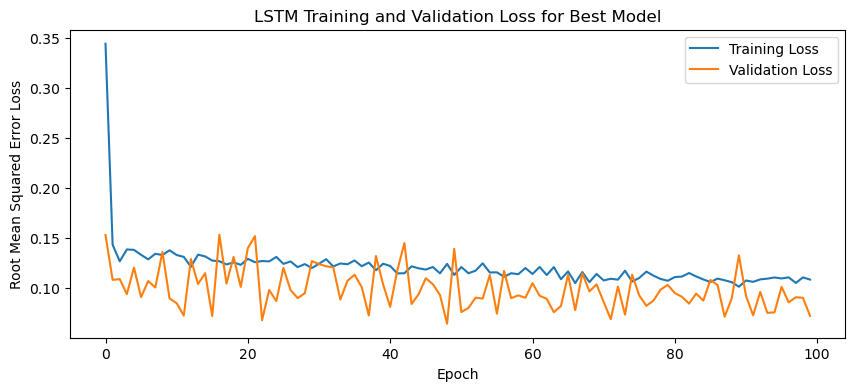

1/1 - 2s - loss: 0.0899 - 2s/epoch - 2s/step
Test Loss: 0.08993019908666611
Fold 3:
Epoch 1/100
19/19 [==============================] - 14s 259ms/step - loss: 0.2564 - val_loss: 0.1601
Epoch 2/100
19/19 [==============================] - 1s 40ms/step - loss: 0.1383 - val_loss: 0.1912
Epoch 3/100
19/19 [==============================] - 1s 52ms/step - loss: 0.1390 - val_loss: 0.0960
Epoch 4/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1423 - val_loss: 0.1479
Epoch 5/100
19/19 [==============================] - 1s 50ms/step - loss: 0.1375 - val_loss: 0.1288
Epoch 6/100
19/19 [==============================] - 1s 27ms/step - loss: 0.1411 - val_loss: 0.0978
Epoch 7/100
19/19 [==============================] - 0s 18ms/step - loss: 0.1448 - val_loss: 0.1356
Epoch 8/100
19/19 [==============================] - 2s 104ms/step - loss: 0.1415 - val_loss: 0.1836
Epoch 9/100
19/19 [==============================] - 0s 18ms/step - loss: 0.1469 - val_loss: 0.1521
Epoch 10/100


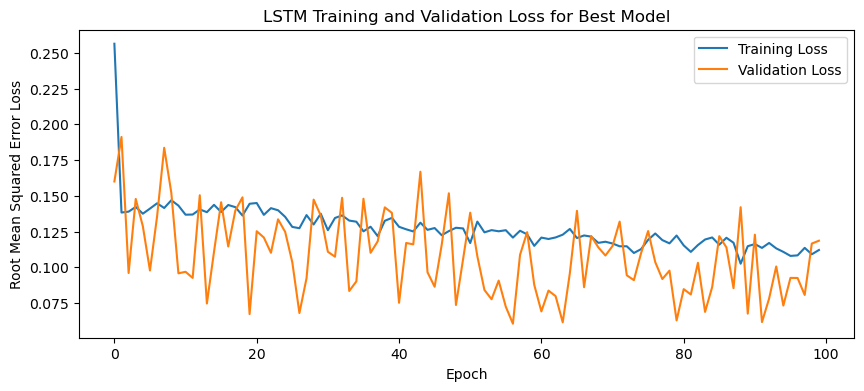

1/1 - 3s - loss: 0.0727 - 3s/epoch - 3s/step
Test Loss: 0.07268495112657547
Fold 4:
Epoch 1/100
20/20 [==============================] - 9s 111ms/step - loss: 0.2319 - val_loss: 0.1734
Epoch 2/100
20/20 [==============================] - 1s 31ms/step - loss: 0.1288 - val_loss: 0.2121
Epoch 3/100
20/20 [==============================] - 1s 32ms/step - loss: 0.1307 - val_loss: 0.1611
Epoch 4/100
20/20 [==============================] - 0s 19ms/step - loss: 0.1260 - val_loss: 0.1474
Epoch 5/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1346 - val_loss: 0.1277
Epoch 6/100
20/20 [==============================] - 1s 25ms/step - loss: 0.1205 - val_loss: 0.2743
Epoch 7/100
20/20 [==============================] - 2s 84ms/step - loss: 0.1300 - val_loss: 0.1808
Epoch 8/100
20/20 [==============================] - 0s 23ms/step - loss: 0.1264 - val_loss: 0.1391
Epoch 9/100
20/20 [==============================] - 1s 31ms/step - loss: 0.1310 - val_loss: 0.1404
Epoch 10/100
20

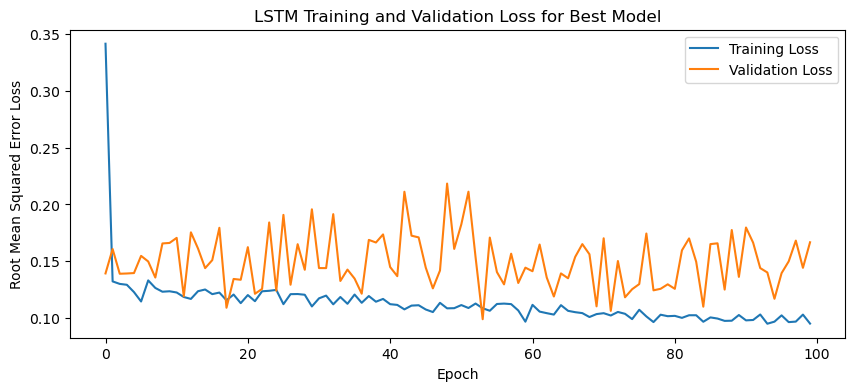

1/1 - 4s - loss: 0.0711 - 4s/epoch - 4s/step
Test Loss: 0.07113334536552429


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

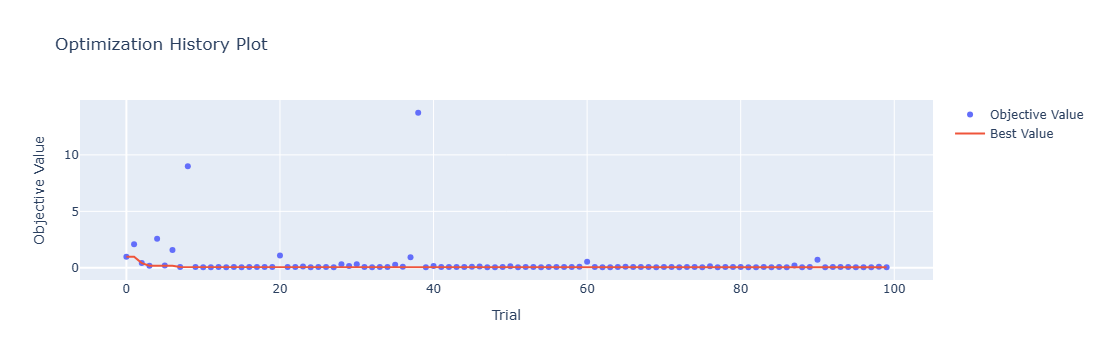

In [4]:
optuna.visualization.plot_optimization_history(study)

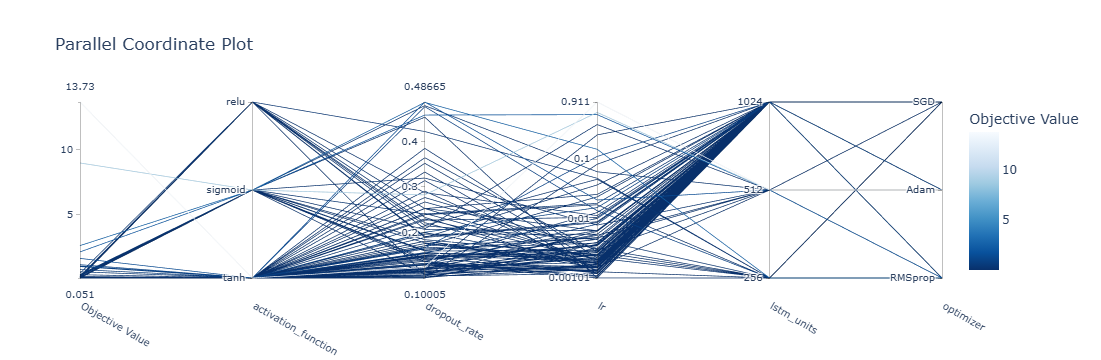

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

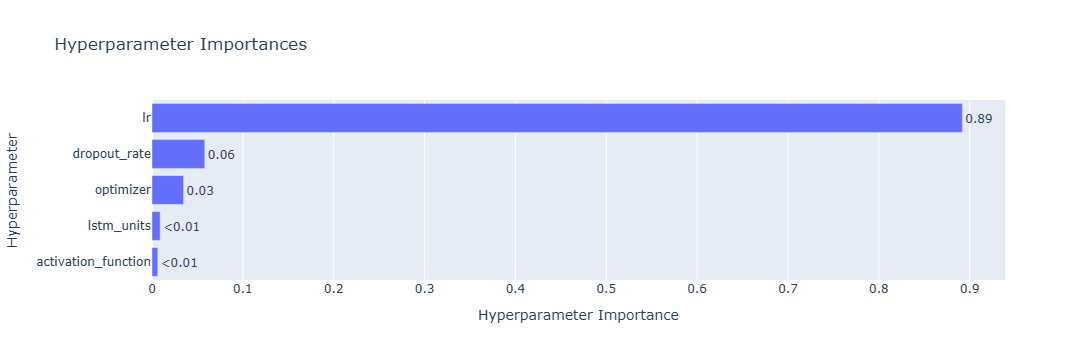

In [6]:
optuna.visualization.plot_param_importances(study)

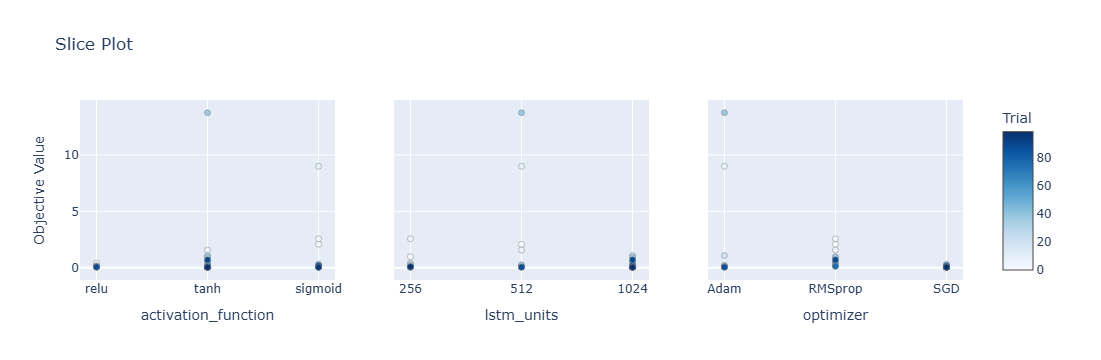

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

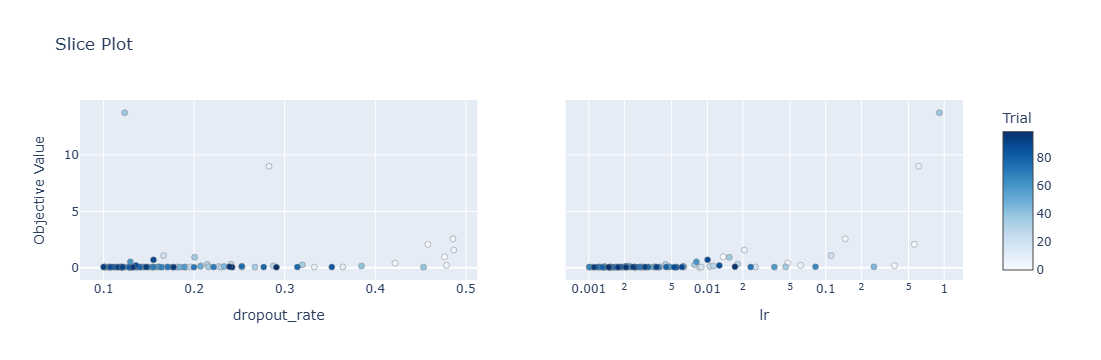

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 21s 413ms/step - loss: 0.5570 - accuracy: 0.0526 - mae: 0.5394 - rmse: 0.5570 - mape: 93.3181 - pearson: 0.0850 - val_loss: 0.4974 - val_accuracy: 0.0000e+00 - val_mae: 0.4844 - val_rmse: 0.4974 - val_mape: 85.0904 - val_pearson: 0.1572
Epoch 2/100
19/19 [==============================] - 1s 68ms/step - loss: 0.4713 - accuracy: 0.1579 - mae: 0.4538 - rmse: 0.4713 - mape: 78.3115 - pearson: 0.2501 - val_loss: 0.4104 - val_accuracy: 0.0000e+00 - val_mae: 0.3974 - val_rmse: 0.4104 - val_mape: 69.8533 - val_pearson: 0.3242
Epoch 3/100
19/19 [==============================] - 1s 64ms/step - loss: 0.3835 - 

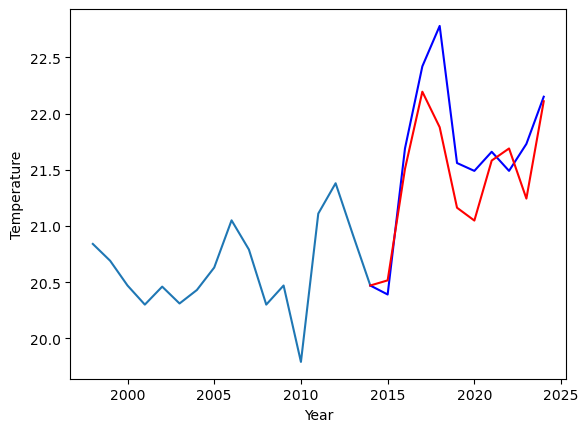

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.37		16.26		-0.11
17.64		17.26		-0.38
17.80		17.94		0.14
18.04		17.62		-0.42
18.00		16.91		-1.09
18.95		16.81		-2.14
18.12		17.35		-0.77
17.61		17.47		-0.14
17.89		17.02		-0.87
17.72		17.88		0.16


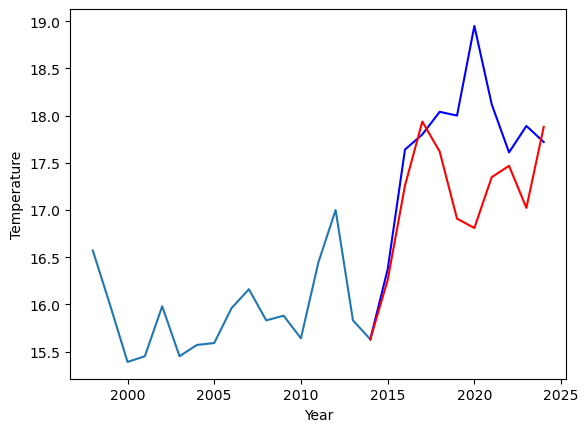

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.39  20.515758
1                1   16.37  16.256560


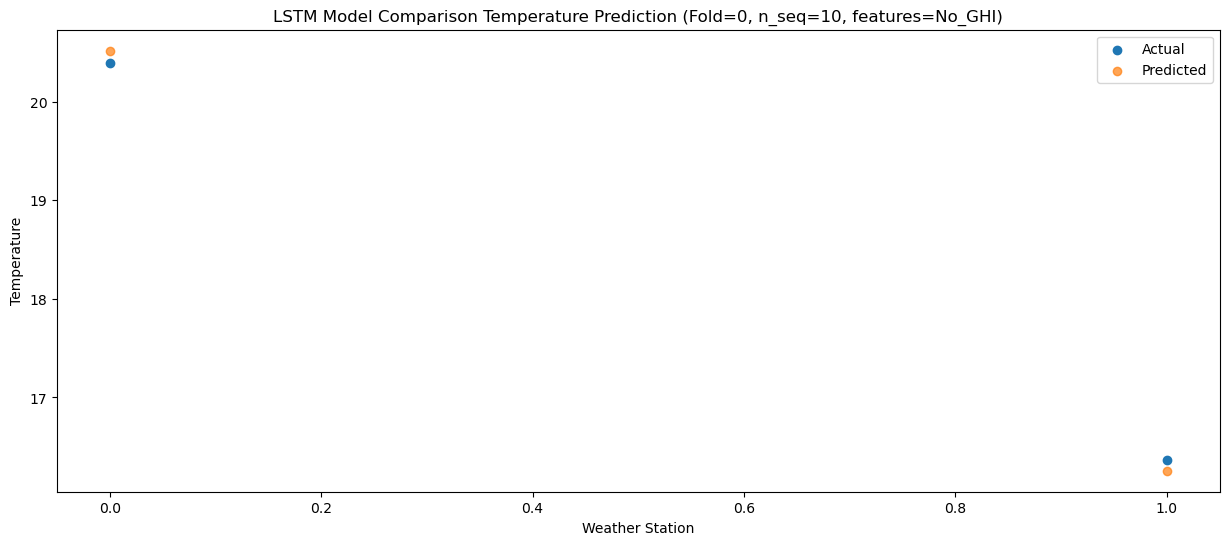

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.69  21.508266
1                1   17.64  17.259083


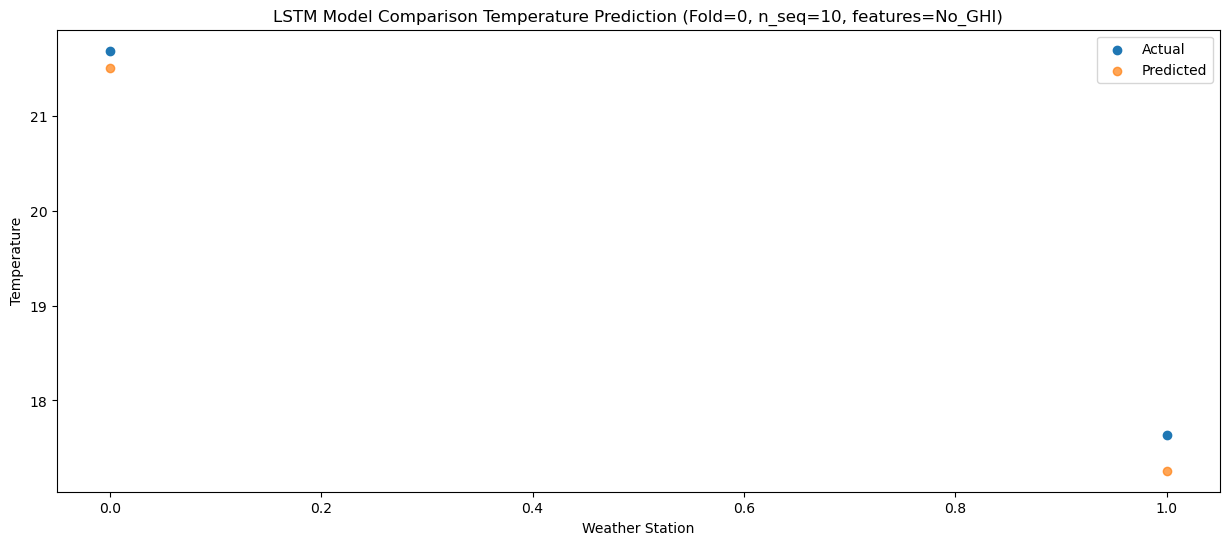

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.42  22.194681
1                1   17.80  17.936765


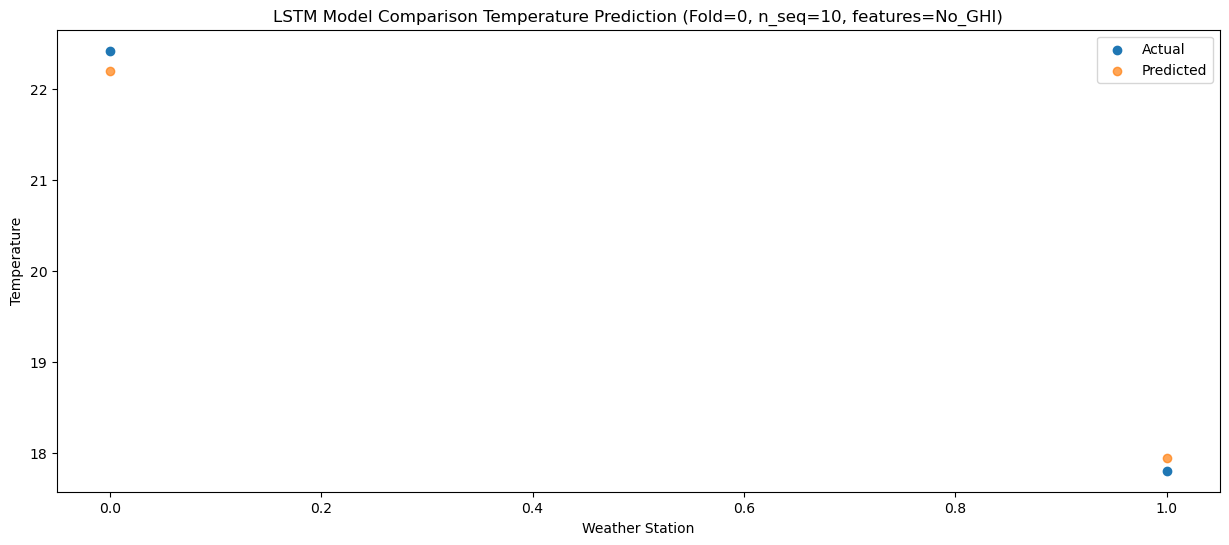

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.78  21.878532
1                1   18.04  17.618584


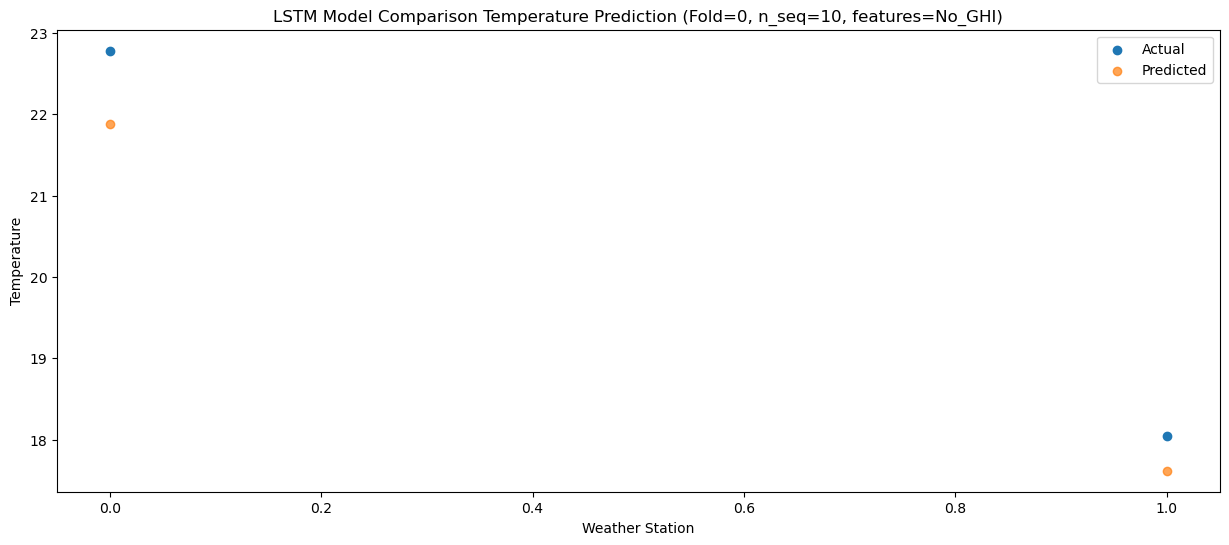

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.56  21.162178
1                1   18.00  16.908096


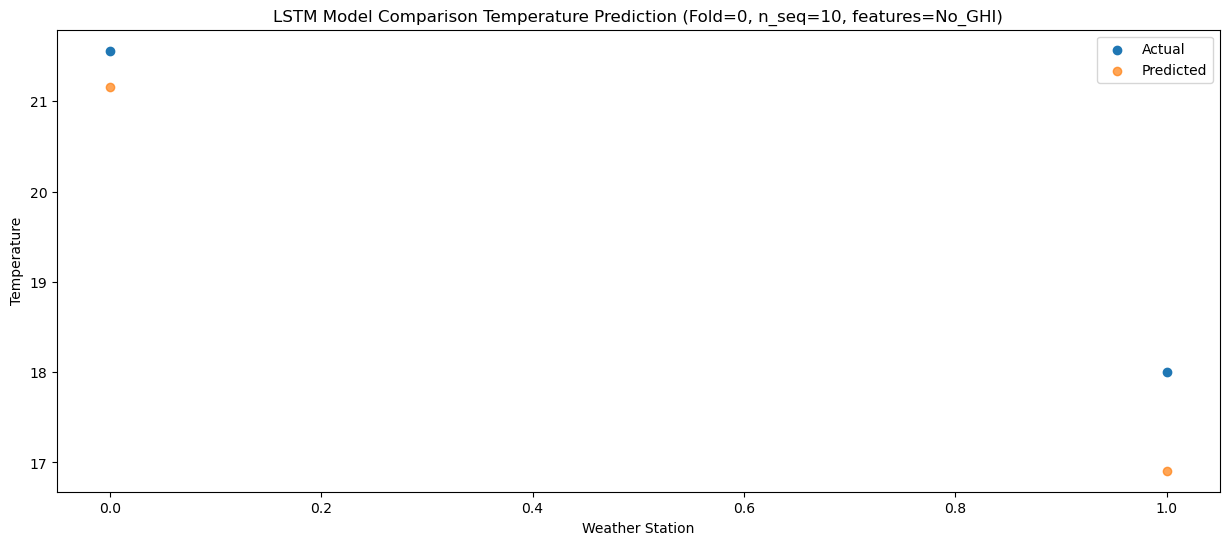

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.49   21.04800
1                1   18.95   16.80889


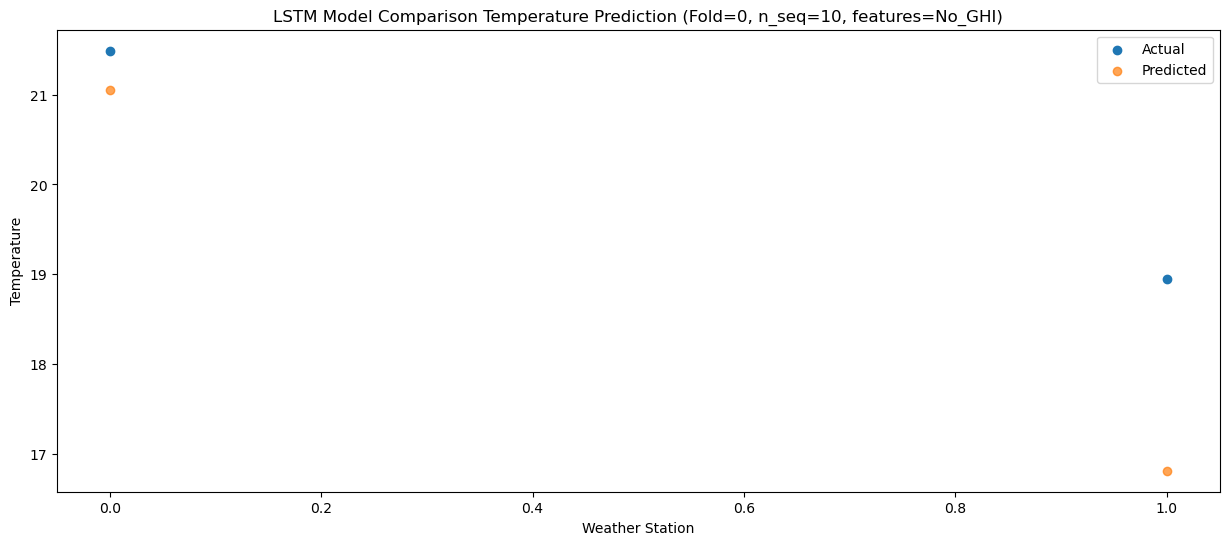

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   21.66  21.582142
1                1   18.12  17.347085


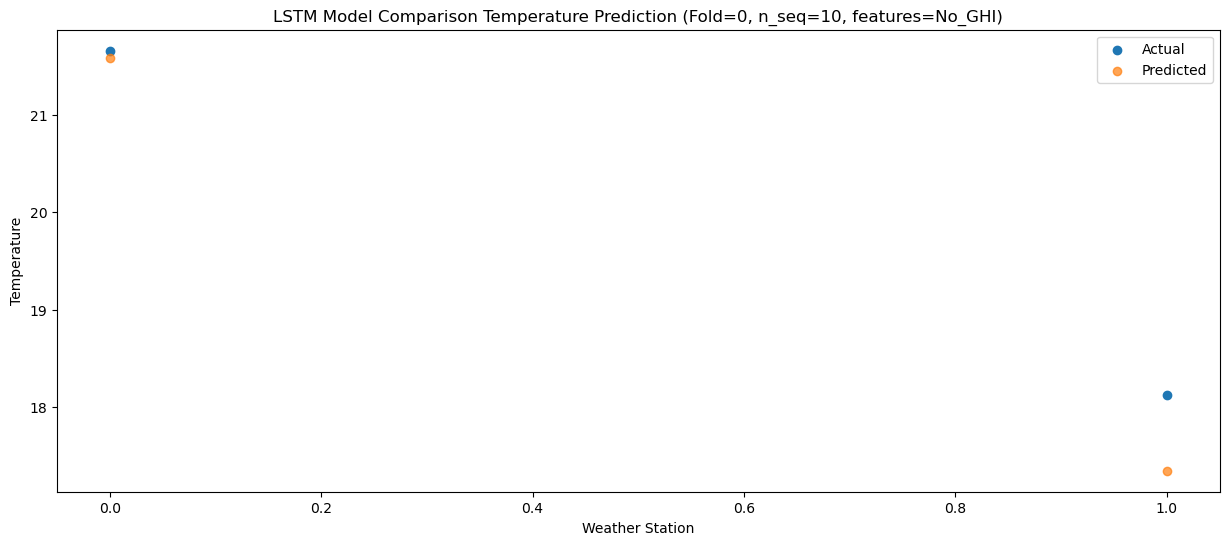

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.49  21.689591
1                1   17.61  17.467891


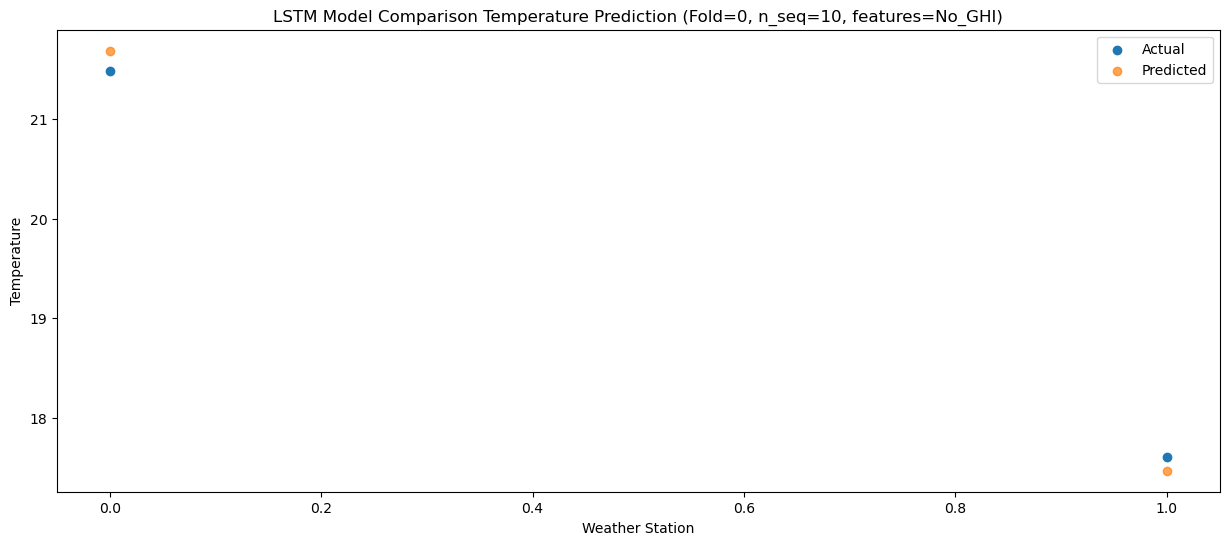

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   21.73  21.243535
1                1   17.89  17.022174


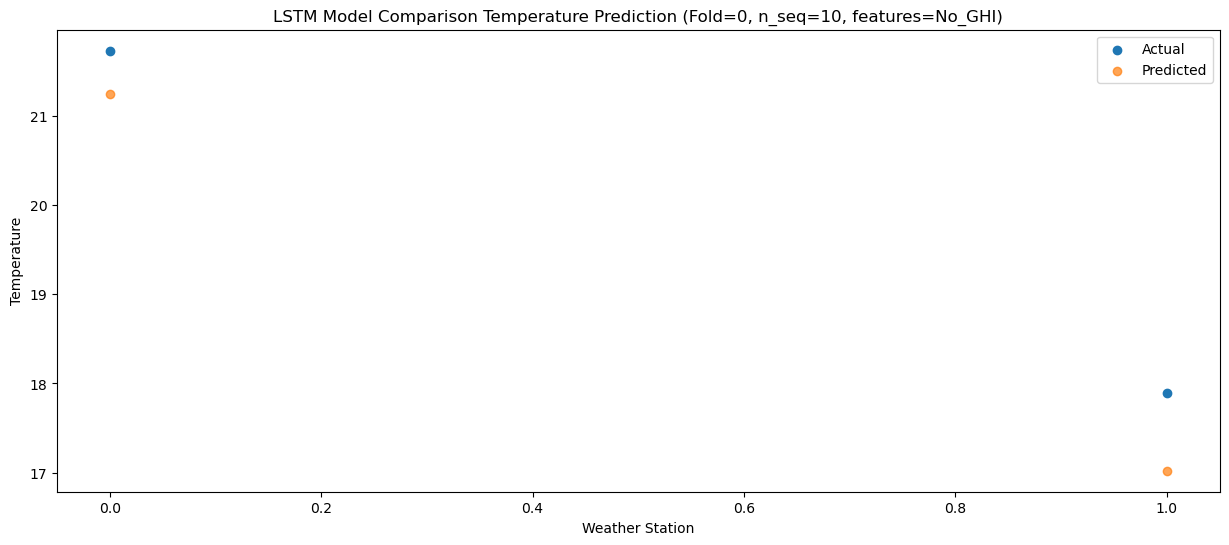

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   22.15  22.109837
1                1   17.72  17.880476


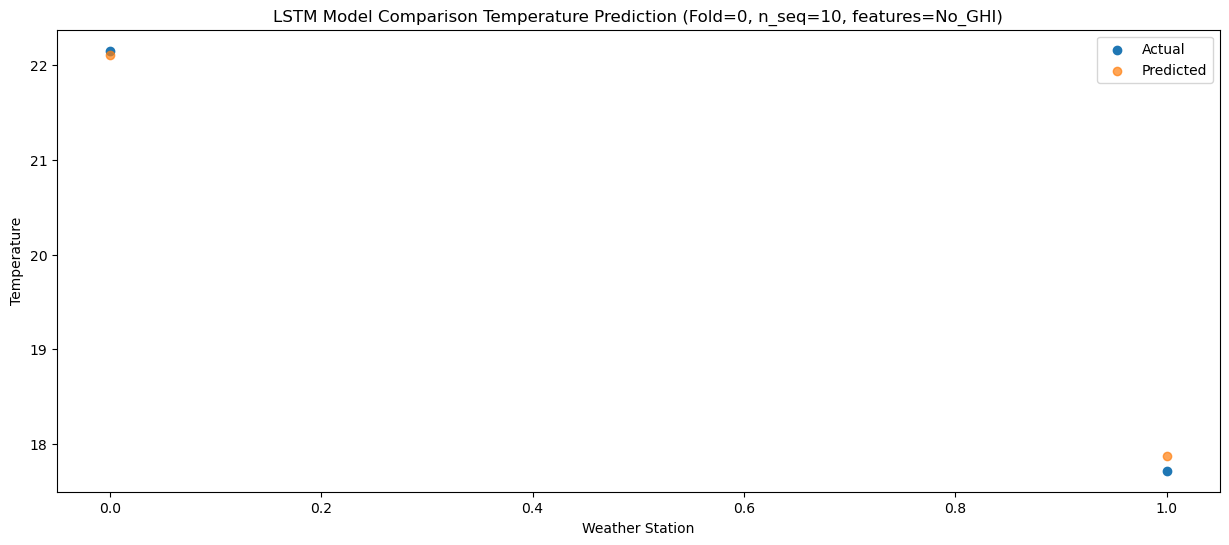

f, t:
[[20.39 16.37]
 [21.69 17.64]
 [22.42 17.8 ]
 [22.78 18.04]
 [21.56 18.  ]
 [21.49 18.95]
 [21.66 18.12]
 [21.49 17.61]
 [21.73 17.89]
 [22.15 17.72]]
[[20.51575806 16.2565603 ]
 [21.50826588 17.25908313]
 [22.19468131 17.93676535]
 [21.87853238 17.61858422]
 [21.16217848 16.90809638]
 [21.04800009 16.80888967]
 [21.58214157 17.34708534]
 [21.68959136 17.4678912 ]
 [21.24353467 17.0221741 ]
 [22.10983722 17.88047592]]
Year at t+1:
t+1 SKRMSE: 0.119757
t+1 KRMSE: 0.119757
t+1 MAE: 0.119599
t+1 SKMAPE: 0.006549
t+1 R2_SCORE: 0.996450
t+1 KMAPE: 0.006549
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.298433
t+2 KRMSE: 0.298433
t+2 MAE: 0.281325
t+2 SKMAPE: 0.014986
t+2 R2_SCORE: 0.978281
t+2 KMAPE: 0.014986
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.186378
t+3 KRMSE: 0.186378
t+3 MAE: 0.181042
t+3 SKMAPE: 0.008867
t+3 R2_SCORE: 0.993490
t+3 KMAPE: 0.008867
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.703646
t+4 KRMSE: 0.703646
t+4 MAE: 0.661442
t+4 SKMAPE: 0.031466
t+4 R

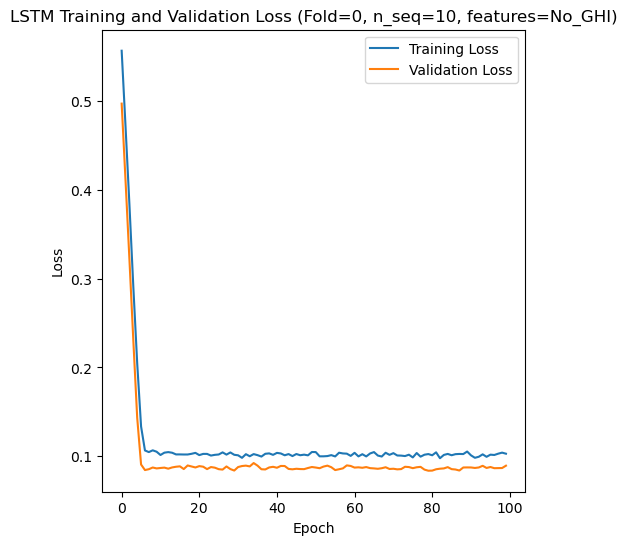

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 18s 227ms/step - loss: 0.5902 - accuracy: 0.2105 - mae: 0.5784 - rmse: 0.5902 - mape: 91.3778 - pearson: 0.1783 - val_loss: 0.5263 - val_accuracy: 0.0000e+00 - val_mae: 0.5147 - val_rmse: 0.5263 - val_mape: 81.0949 - val_pearson: 0.3454
Epoch 2/100
19/19 [==============================] - 1s 79ms/step - loss: 0.4711 - accuracy: 0.1053 - mae: 0.4573 - rmse: 0.4711 - mape: 71.7058 - pearson: 0.2386 - val_loss: 0.4081 - val_accuracy: 0.0000e+00 - val_mae: 0.3936 - val_rmse: 0.4081 - val_mape: 61.2363 - val_pearson: 0.2827
Epoch 3/100
19/19 [==============================] - 2s 83ms/step - loss: 0.3500 - a

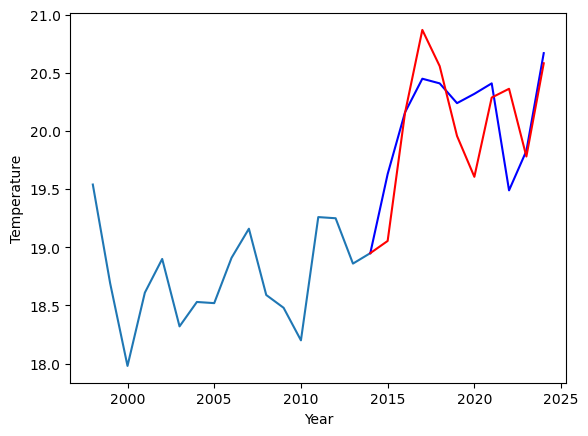

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.88		19.22		-0.66
19.40		20.31		0.91
20.43		21.01		0.58
20.81		20.71		-0.10
19.96		20.11		0.15
20.09		19.76		-0.33
20.61		20.43		-0.18
20.22		20.51		0.29
20.22		19.92		-0.30
21.53		20.71		-0.82


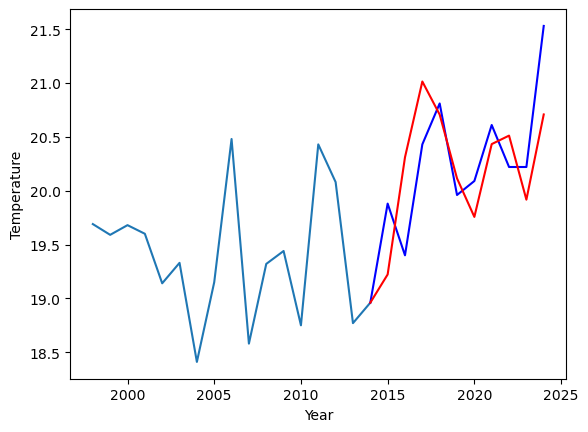

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.63  19.054758
1                1   19.88  19.222149


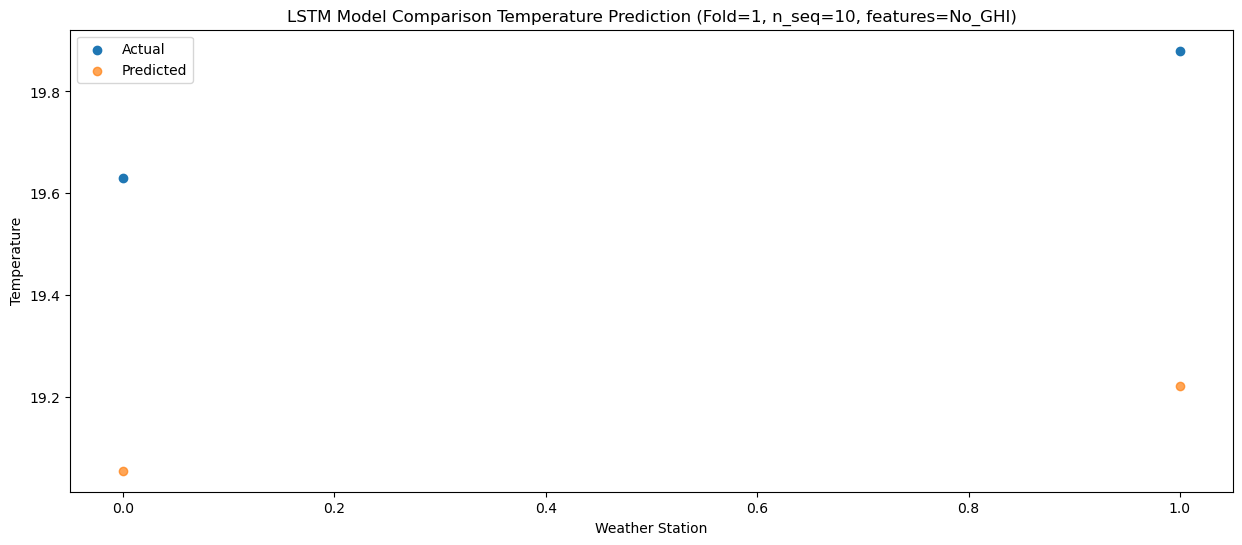

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.16  20.154557
1                1   19.40  20.310179


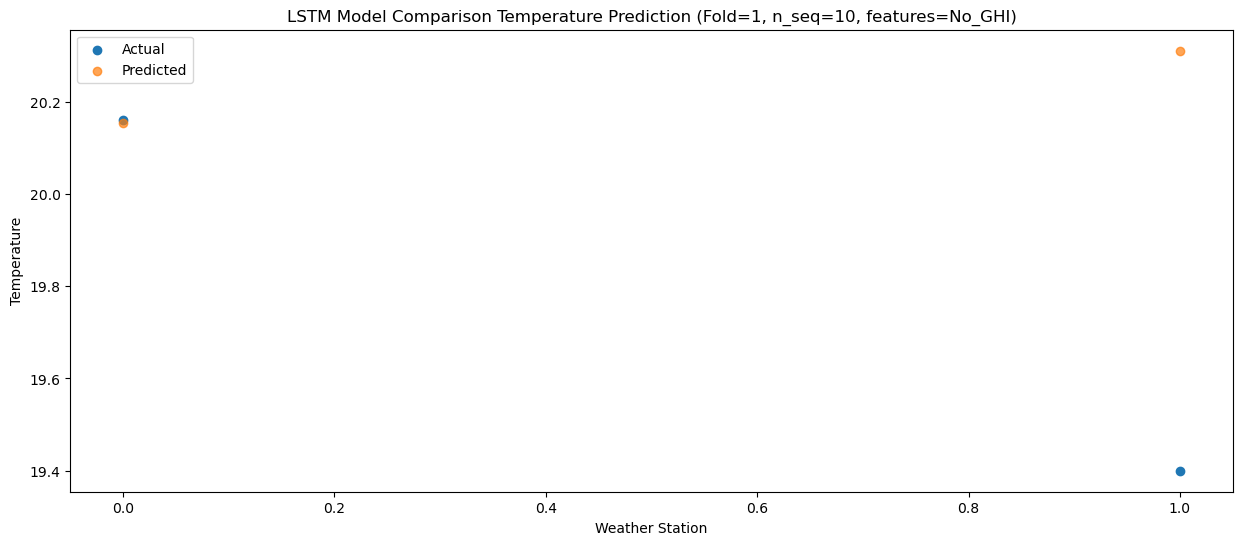

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.45  20.869695
1                1   20.43  21.013917


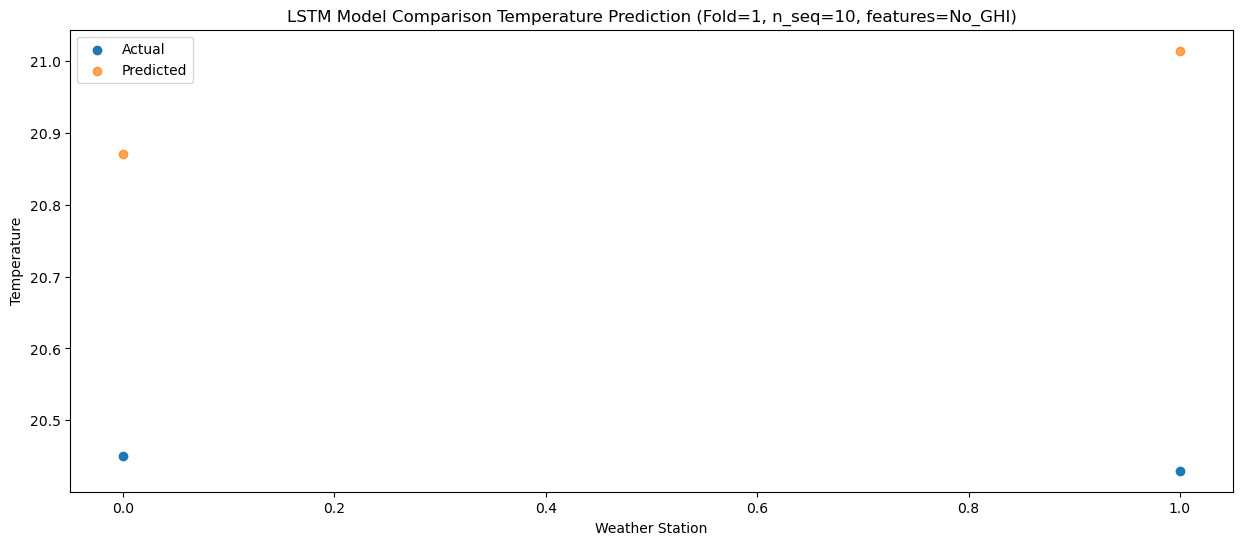

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   20.41  20.558411
1                1   20.81  20.706645


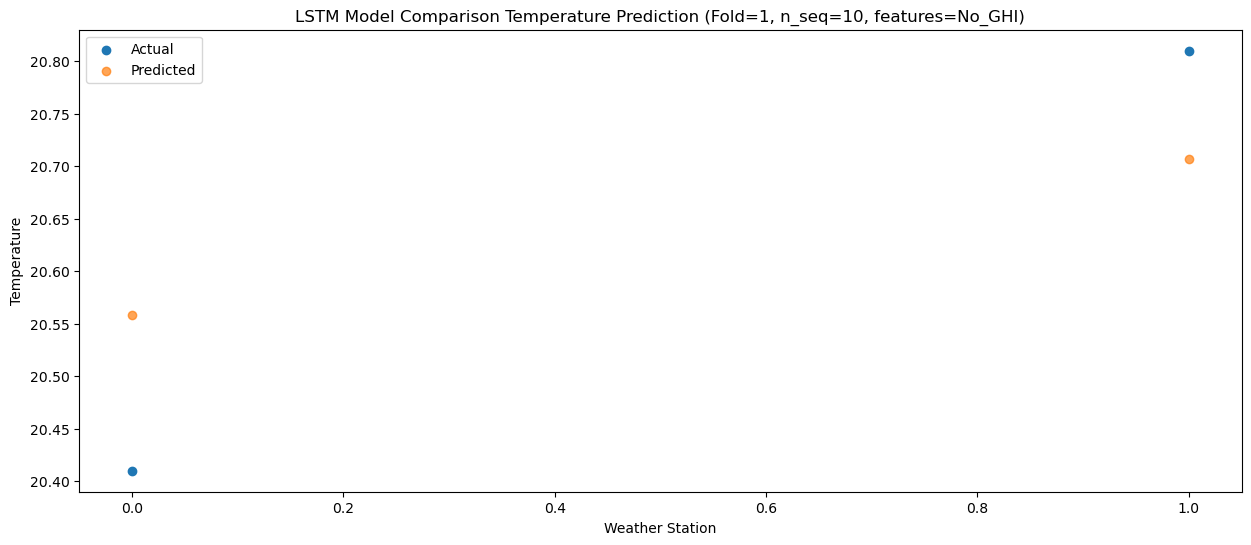

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   20.24  19.957823
1                1   19.96  20.114370


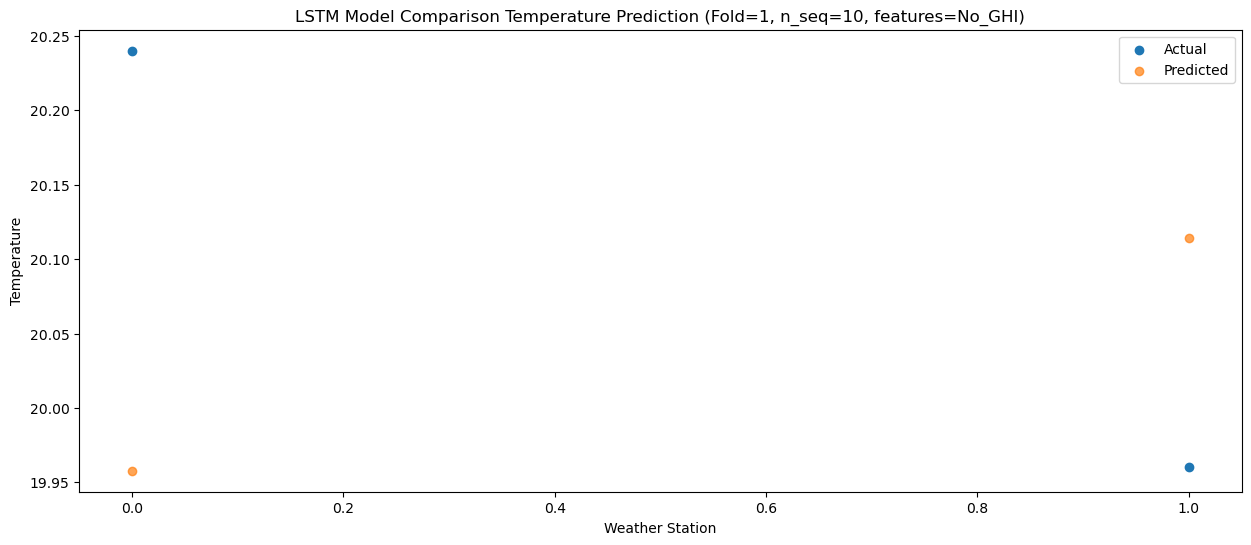

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   20.32  19.606435
1                1   20.09  19.756664


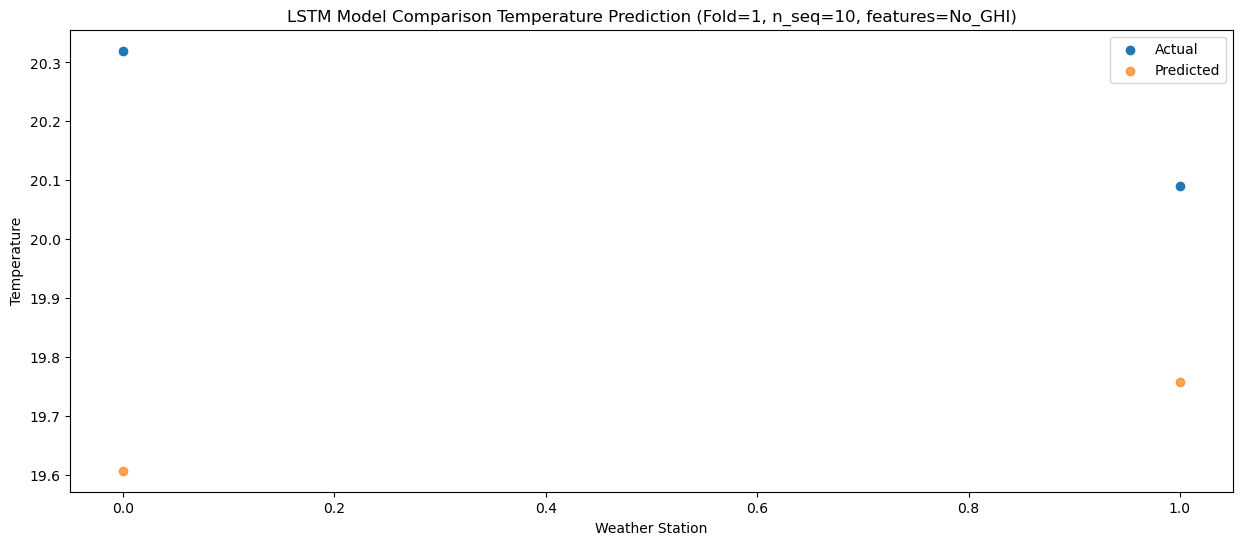

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   20.41  20.288085
1                1   20.61  20.432625


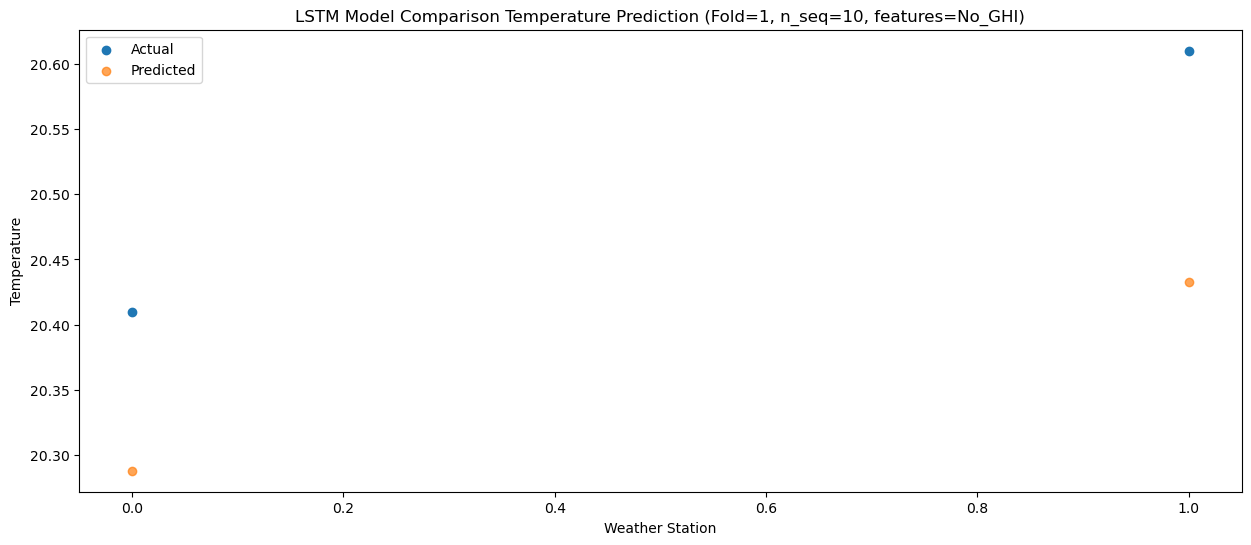

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   19.49  20.363458
1                1   20.22  20.511505


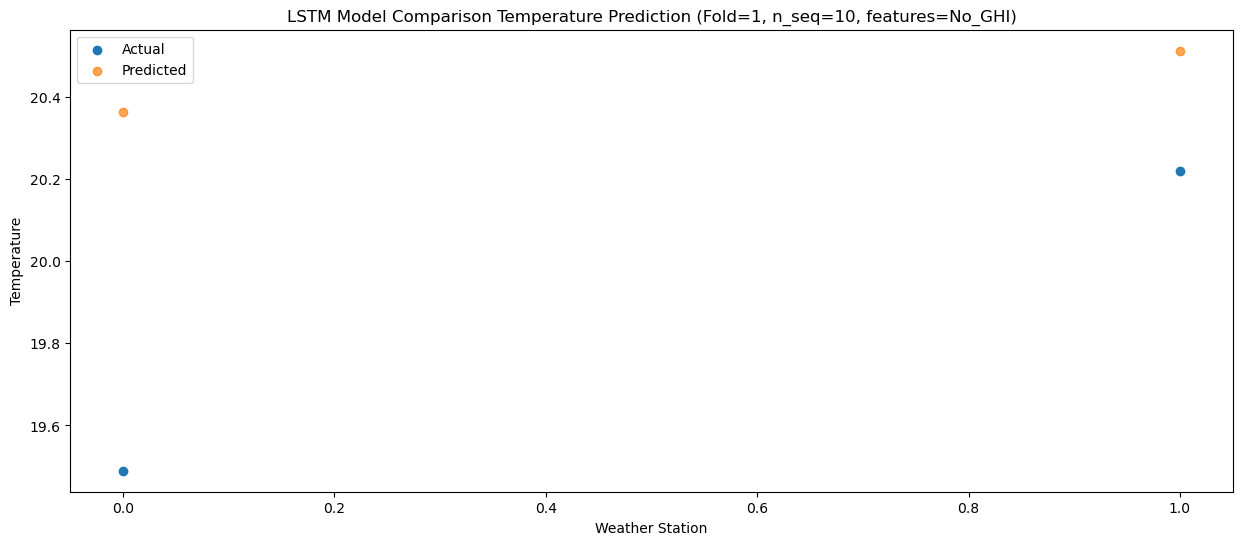

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   19.83  19.781000
1                1   20.22  19.916767


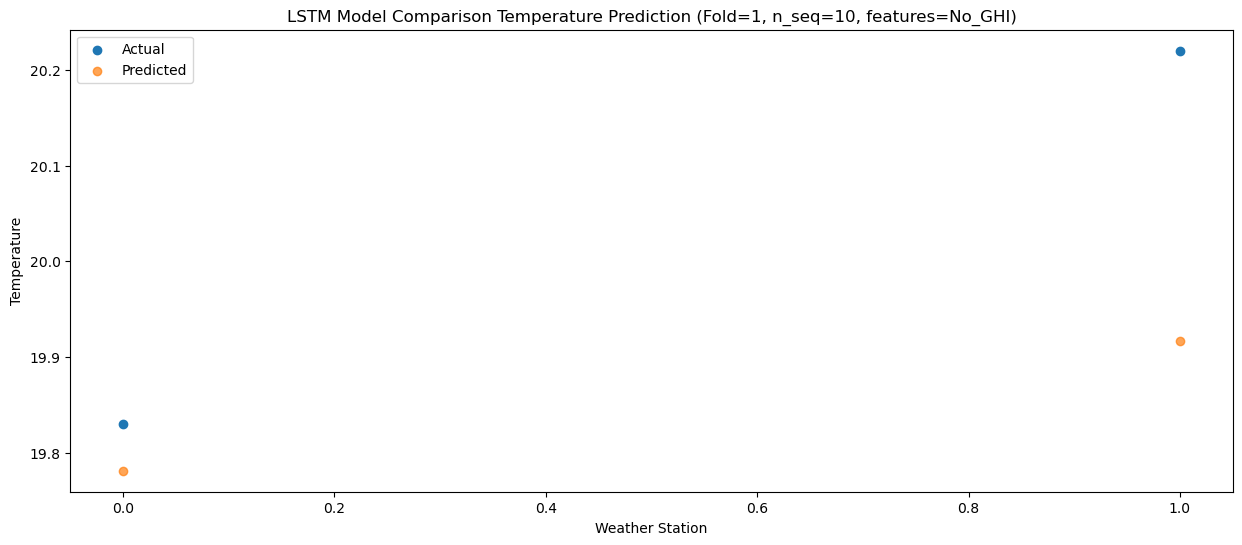

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   20.67  20.582818
1                1   21.53  20.707953


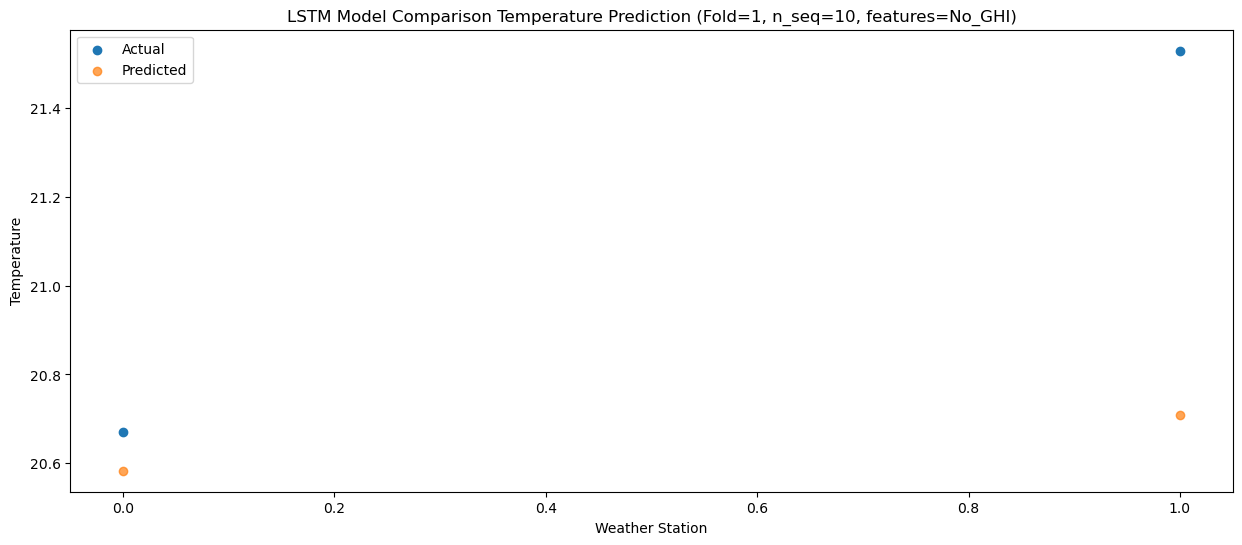

f, t:
[[19.63 19.88]
 [20.16 19.4 ]
 [20.45 20.43]
 [20.41 20.81]
 [20.24 19.96]
 [20.32 20.09]
 [20.41 20.61]
 [19.49 20.22]
 [19.83 20.22]
 [20.67 21.53]]
[[19.05475799 19.22214899]
 [20.15455679 20.31017885]
 [20.86969463 21.01391694]
 [20.55841056 20.70664484]
 [19.95782302 20.11436951]
 [19.60643534 19.7566641 ]
 [20.28808484 20.4326253 ]
 [20.36345784 20.51150545]
 [19.78099988 19.91676697]
 [20.58281796 20.70795276]]
Year at t+1:
t+1 SKRMSE: 0.617929
t+1 KRMSE: 0.617929
t+1 MAE: 0.616547
t+1 SKMAPE: 0.031198
t+1 R2_SCORE: -23.437482
t+1 KMAPE: 0.031198
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.643605
t+2 KRMSE: 0.643605
t+2 MAE: 0.457811
t+2 SKMAPE: 0.023593
t+2 R2_SCORE: -1.868612
t+2 KMAPE: 0.023593
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.508479
t+3 KRMSE: 0.508479
t+3 MAE: 0.501806
t+3 SKMAPE: 0.024552
t+3 R2_SCORE: -2584.512882
t+3 KMAPE: 0.024552
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.127883
t+4 KRMSE: 0.127883
t+4 MAE: 0.125883
t+4 SKMAPE: 0.00611

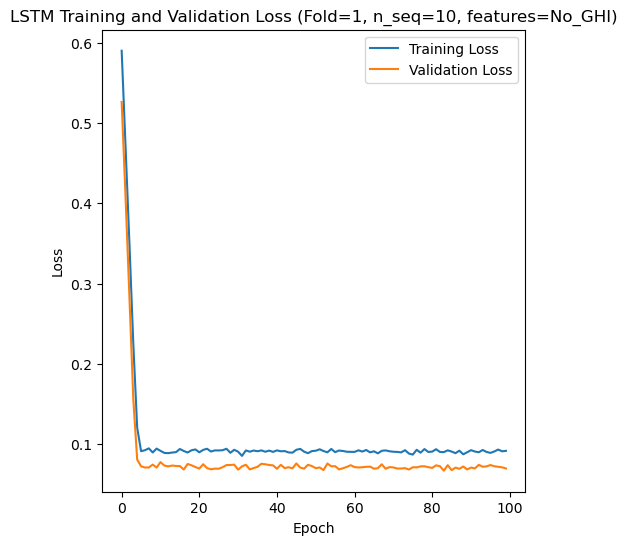

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 16s 285ms/step - loss: 0.5880 - accuracy: 0.0000e+00 - mae: 0.5750 - rmse: 0.5880 - mape: 90.8799 - pearson: 0.1395 - val_loss: 0.5136 - val_accuracy: 0.3333 - val_mae: 0.5078 - val_rmse: 0.5136 - val_mape: 80.3593 - val_pearson: 0.3640
Epoch 2/100
19/19 [==============================] - 2s 89ms/step - loss: 0.4607 - accuracy: 0.2105 - mae: 0.4455 - rmse: 0.4607 - mape: 69.7968 - pearson: 0.1985 - val_loss: 0.3865 - val_accuracy: 0.3333 - val_mae: 0.3803 - val_rmse: 0.3865 - val_mape: 60.0982 - val_pearson: 0.4583
Epoch 3/100
19/19 [==============================] - 2s 106ms/step - loss: 0.3339 - accu

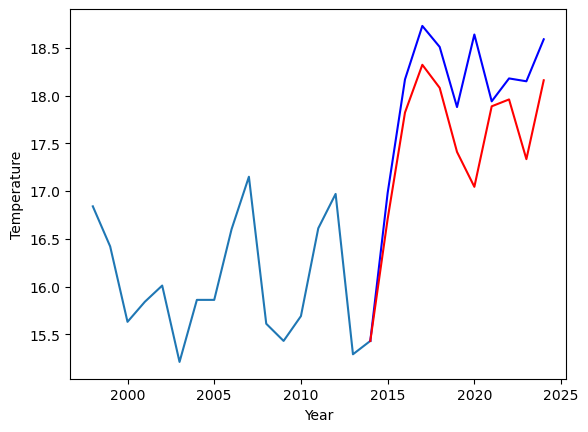

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.89		13.35		0.46
14.23		14.49		0.26
15.00		14.99		-0.01
14.82		14.72		-0.10
14.35		14.04		-0.31
14.68		13.67		-1.01
14.67		14.52		-0.15
14.66		14.60		-0.06
14.20		13.98		-0.22
14.99		14.82		-0.17


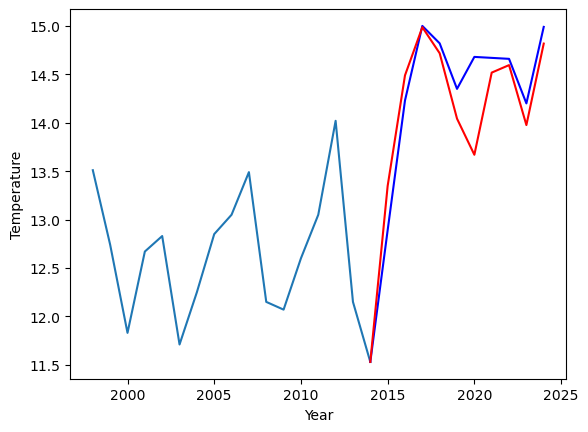

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.98  16.707620
1                1   12.89  13.346912


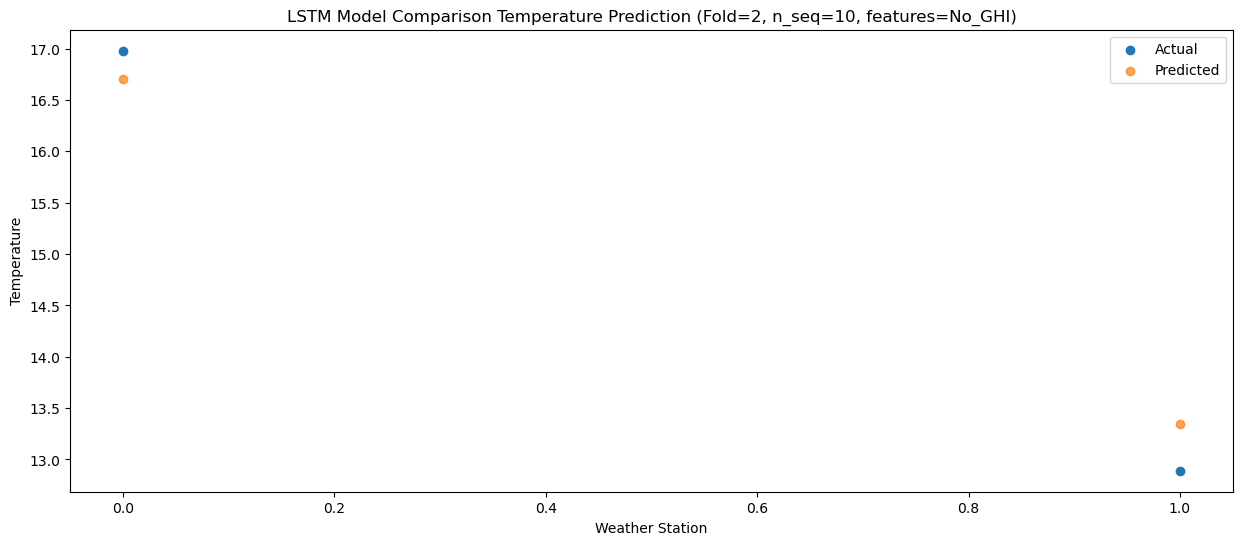

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   18.17  17.822774
1                1   14.23  14.489396


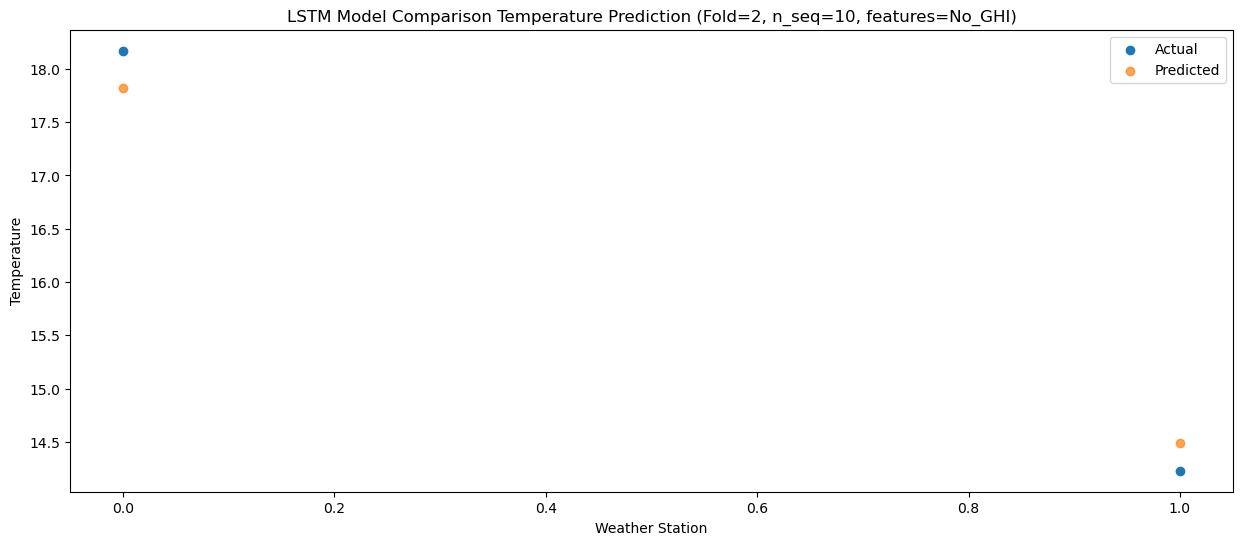

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.73  18.322836
1                1   15.00  14.986625


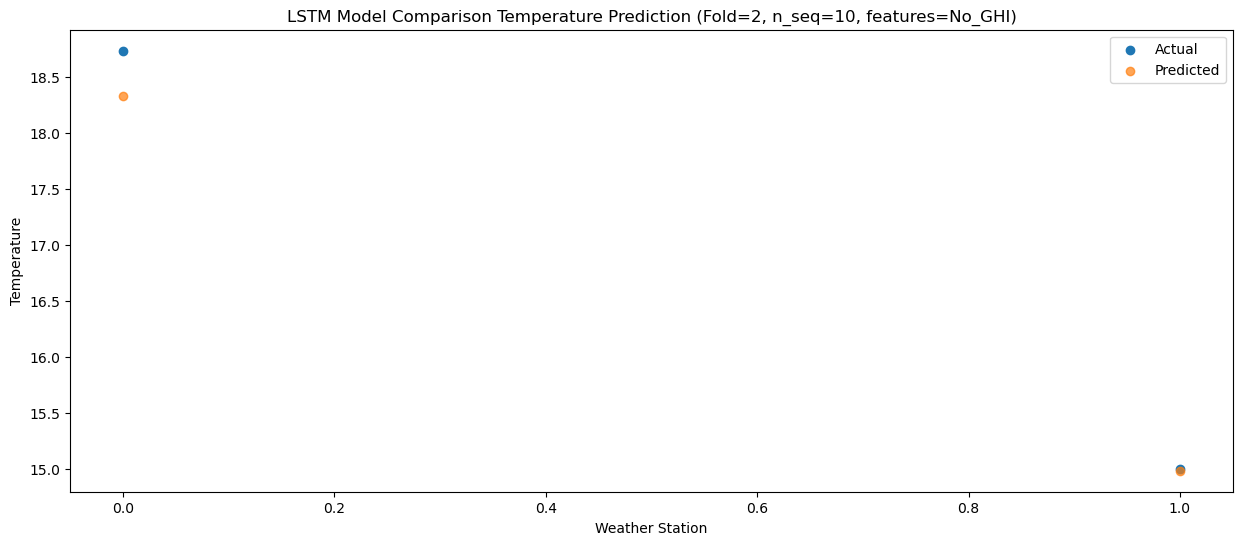

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   18.51  18.081444
1                1   14.82  14.717554


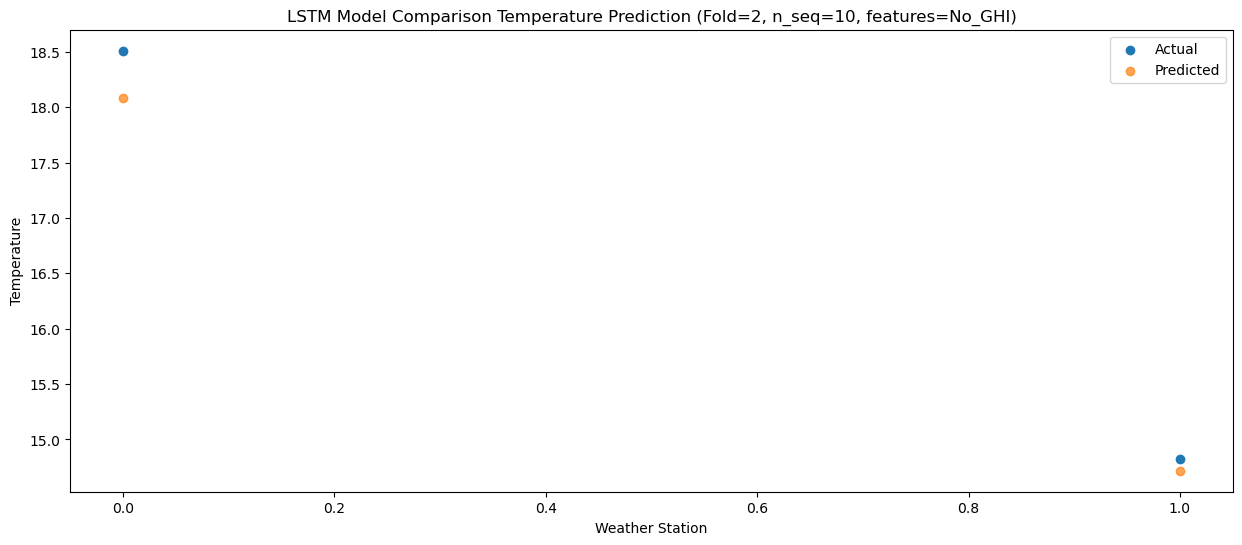

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.88  17.409756
1                1   14.35  14.042365


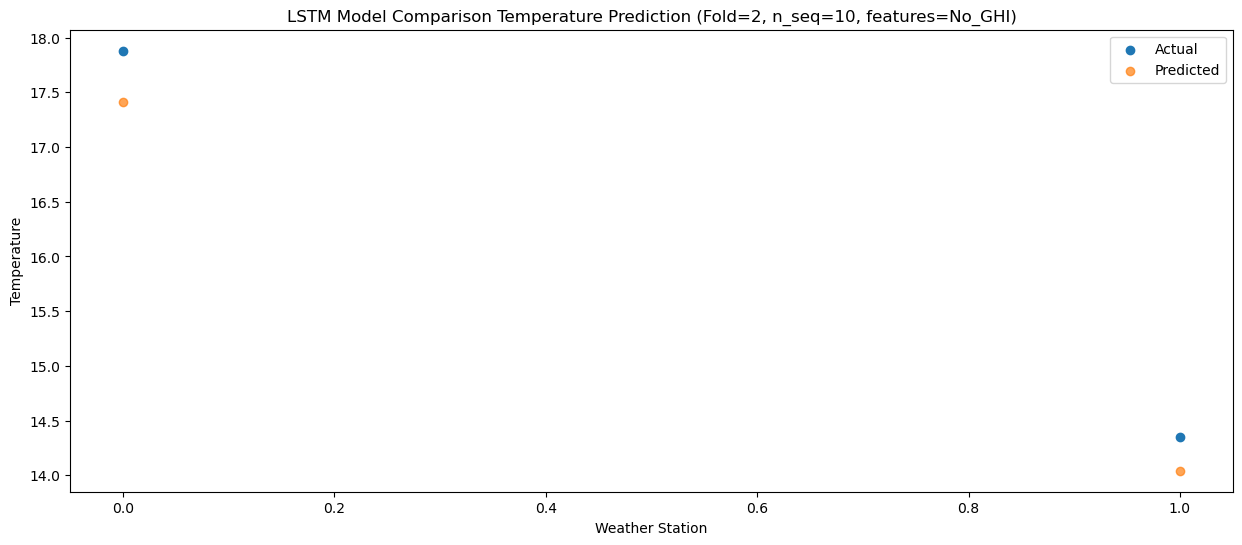

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   18.64  17.044430
1                1   14.68  13.669414


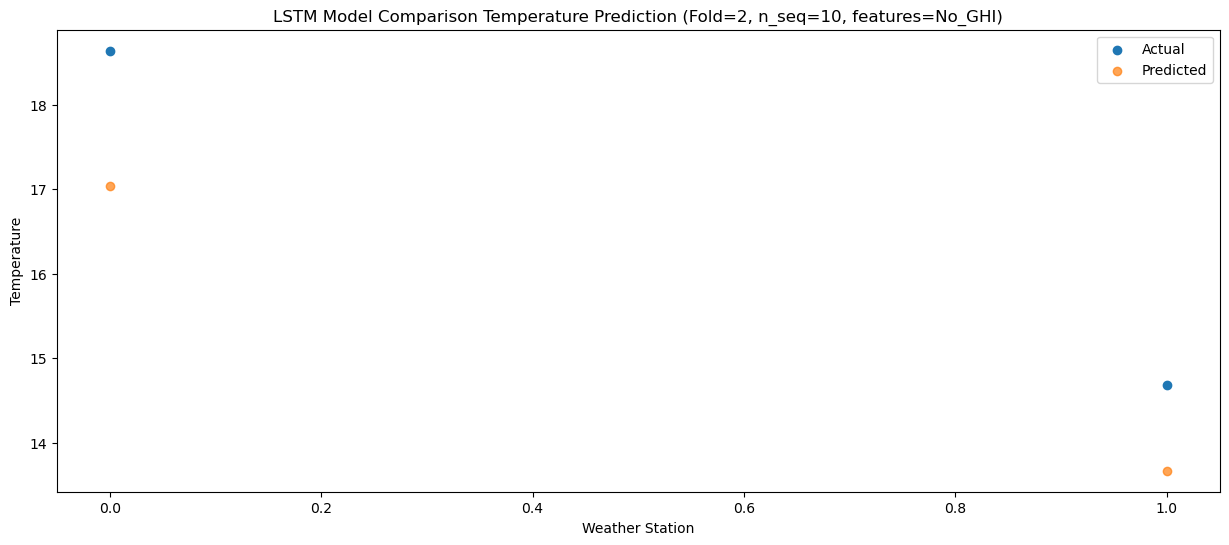

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   17.94  17.887836
1                1   14.67  14.517862


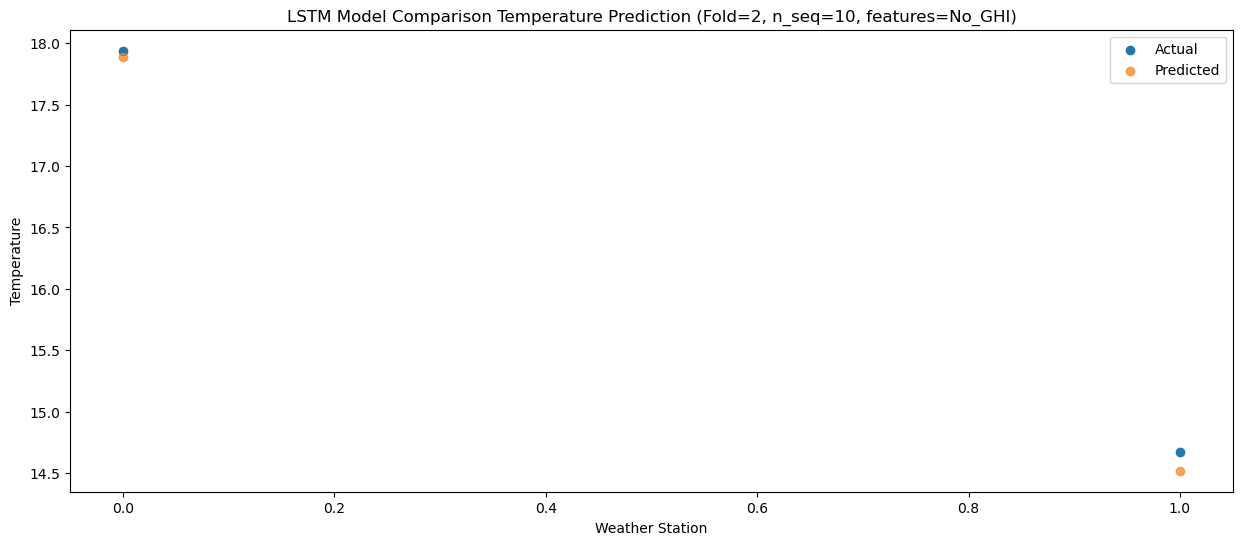

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   18.18  17.959782
1                1   14.66  14.595229


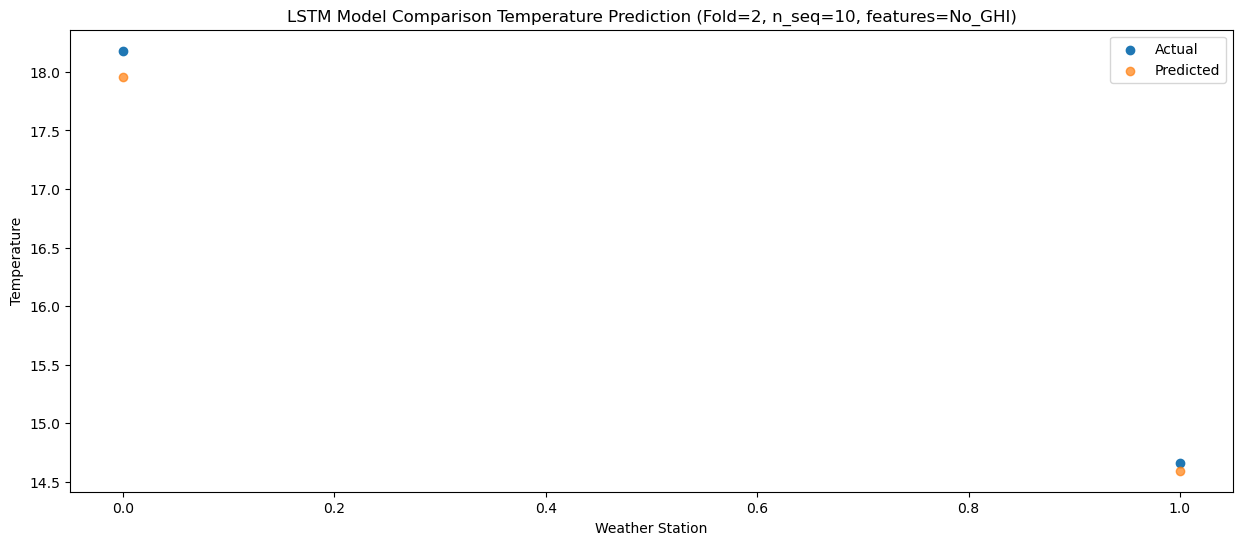

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   18.15  17.334385
1                1   14.20  13.976008


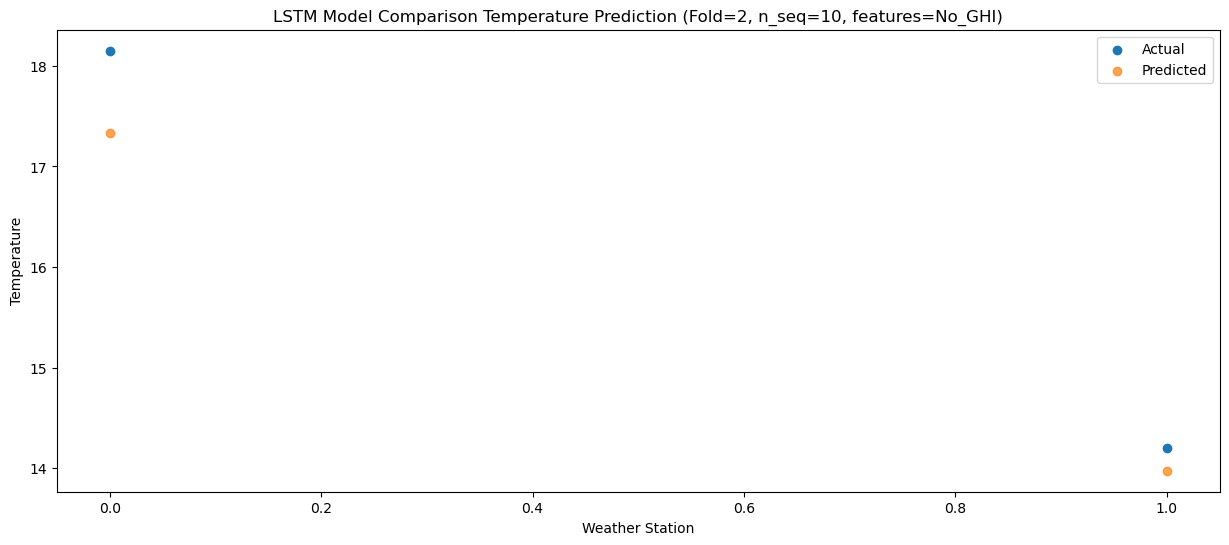

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   18.59  18.160578
1                1   14.99  14.817590


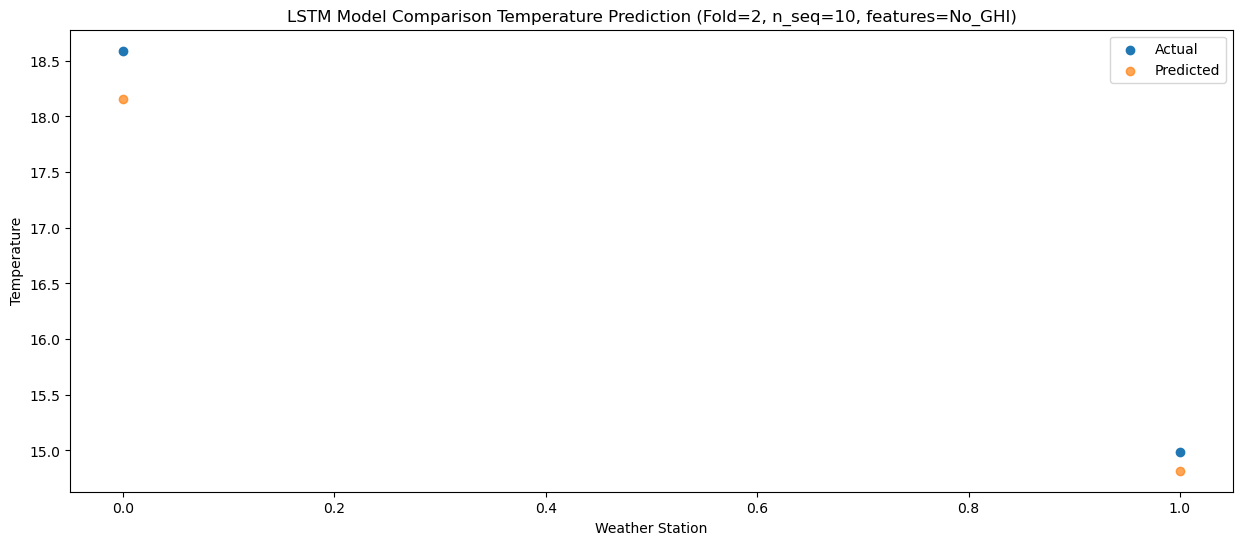

f, t:
[[16.98 12.89]
 [18.17 14.23]
 [18.73 15.  ]
 [18.51 14.82]
 [17.88 14.35]
 [18.64 14.68]
 [17.94 14.67]
 [18.18 14.66]
 [18.15 14.2 ]
 [18.59 14.99]]
[[16.70761951 13.34691154]
 [17.82277378 14.48939621]
 [18.32283583 14.98662543]
 [18.08144438 14.71755439]
 [17.40975576 14.04236489]
 [17.04442969 13.66941437]
 [17.88783553 14.51786151]
 [17.95978236 14.59522853]
 [17.33438539 13.97600834]
 [18.16057813 14.81758968]]
Year at t+1:
t+1 SKRMSE: 0.376138
t+1 KRMSE: 0.376138
t+1 MAE: 0.364646
t+1 SKMAPE: 0.025744
t+1 R2_SCORE: 0.966170
t+1 KMAPE: 0.025744
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.306474
t+2 KRMSE: 0.306474
t+2 MAE: 0.303311
t+2 SKMAPE: 0.018669
t+2 R2_SCORE: 0.975798
t+2 KMAPE: 0.018669
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.288064
t+3 KRMSE: 0.288064
t+3 MAE: 0.210269
t+3 SKMAPE: 0.011315
t+3 R2_SCORE: 0.976143
t+3 KMAPE: 0.011315
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.311573
t+4 KRMSE: 0.311573
t+4 MAE: 0.265501
t+4 SKMAPE: 0.015033
t+4 R

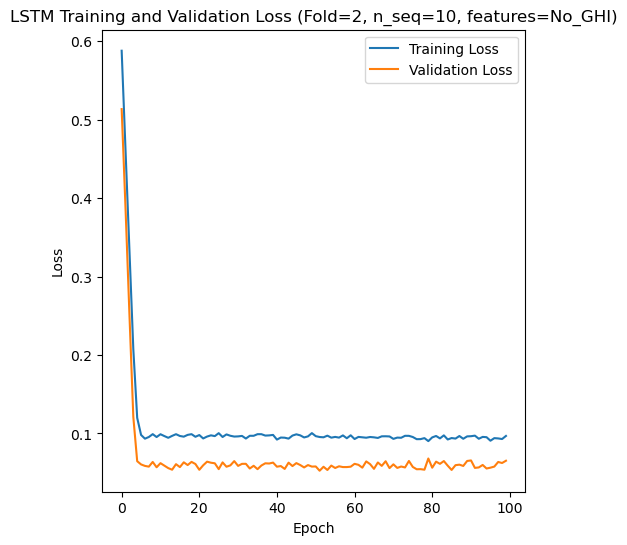

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 19s 264ms/step - loss: 0.6002 - accuracy: 0.0500 - mae: 0.5875 - rmse: 0.6002 - mape: 89.3596 - pearson: 0.0661 - val_loss: 0.5576 - val_accuracy: 0.0000e+00 - val_mae: 0.5230 - val_rmse: 0.5576 - val_mape: 76.7818 - val_pearson: 0.0453
Epoch 2/100
20/20 [==============================] - 2s 79ms/step - loss: 0.4556 - accuracy: 0.0500 - mae: 0.4405 - rmse: 0.4556 - mape: 66.5204 - pearson: 0.1318 - val_loss: 0.4062 - val_accuracy: 0.0000e+00 - val_mae: 0.3688 - val_rmse: 0.4062 - val_mape: 52.9278 - val_pearson: 0.3109
Epoch 3/100
20/20 [==============================] - 2s 79ms/step - loss: 0.3029 - ac

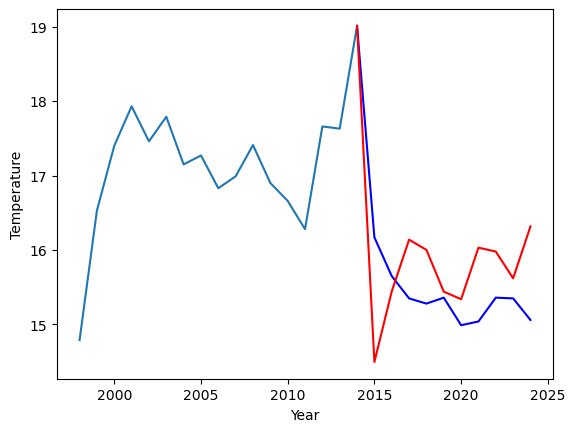

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.03		13.73		0.70
14.13		14.71		0.58
15.42		15.42		0.00
15.25		15.26		0.01
14.76		14.71		-0.05
15.17		14.62		-0.55
15.05		15.29		0.24
14.85		15.24		0.39
14.55		14.89		0.34
15.57		15.61		0.04


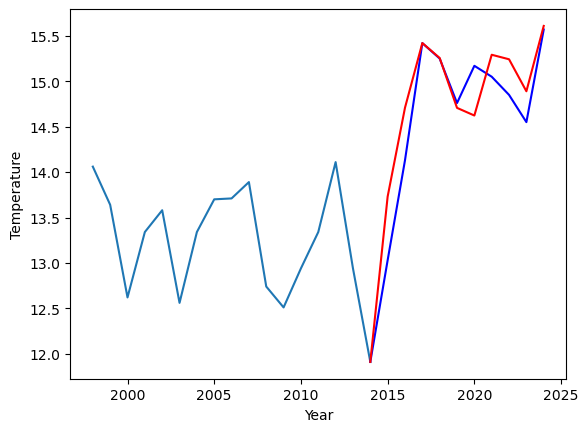

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.17  14.496786
1                1   13.03  13.730737


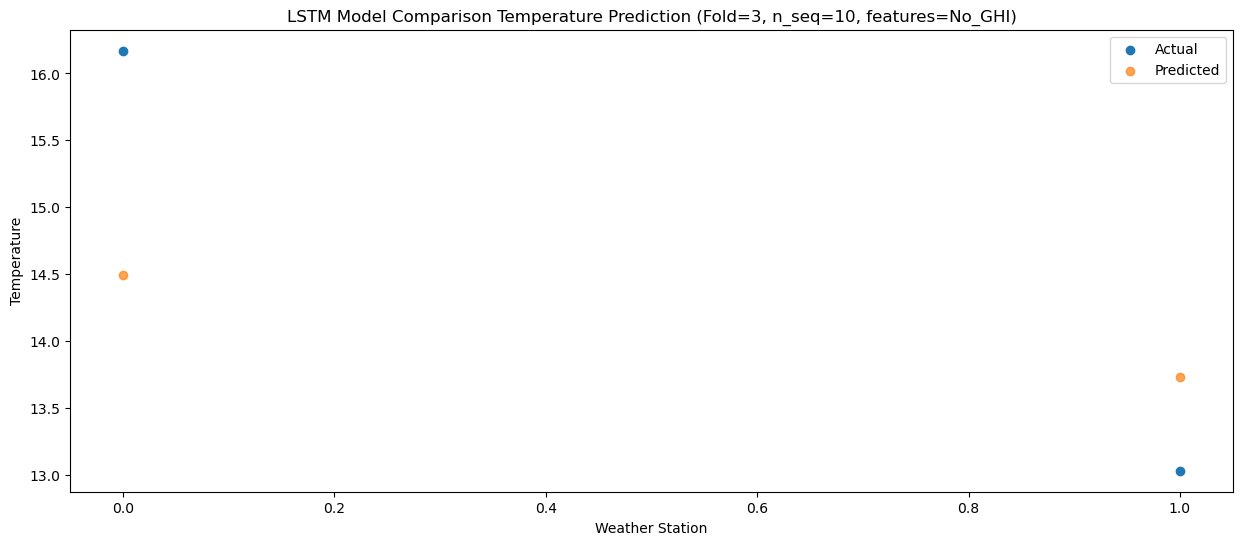

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   15.65  15.444386
1                1   14.13  14.708665


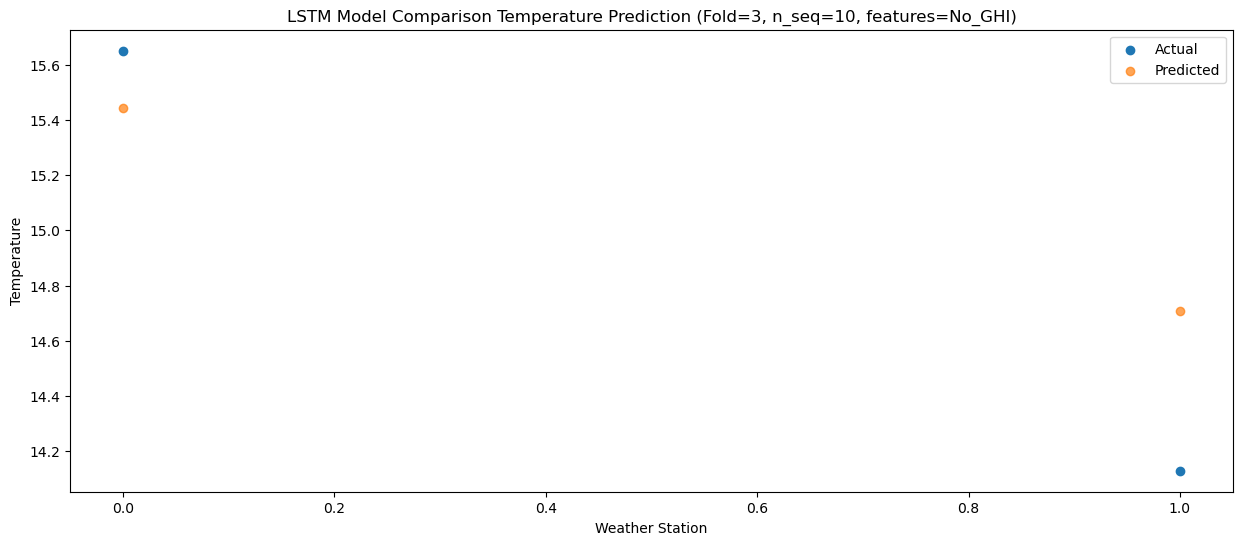

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   15.35  16.138894
1                1   15.42  15.420505


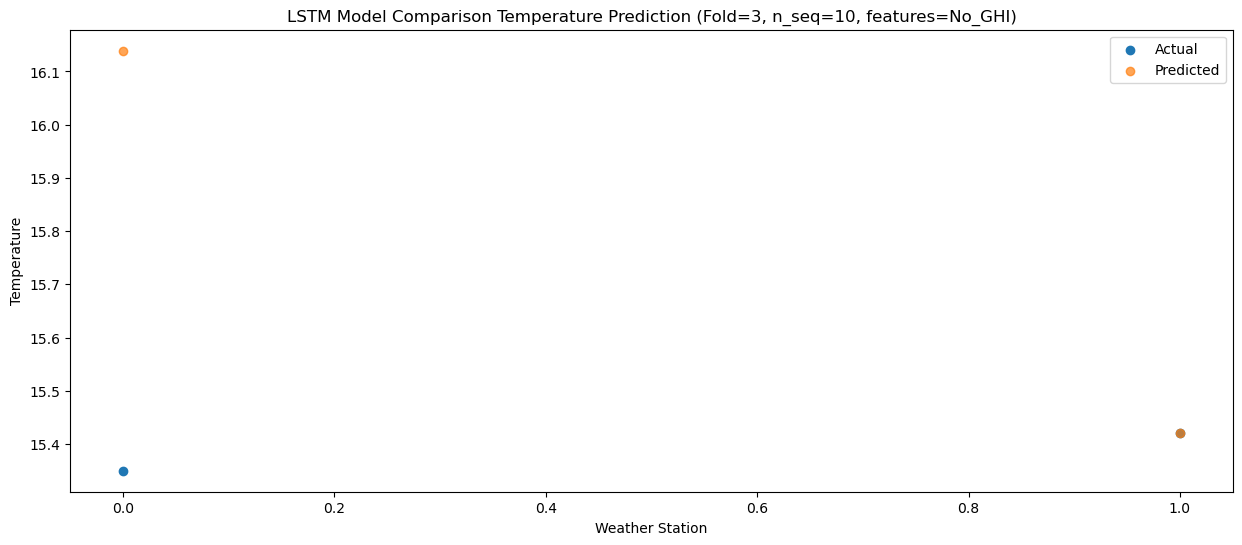

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   15.28  16.001500
1                1   15.25  15.256005


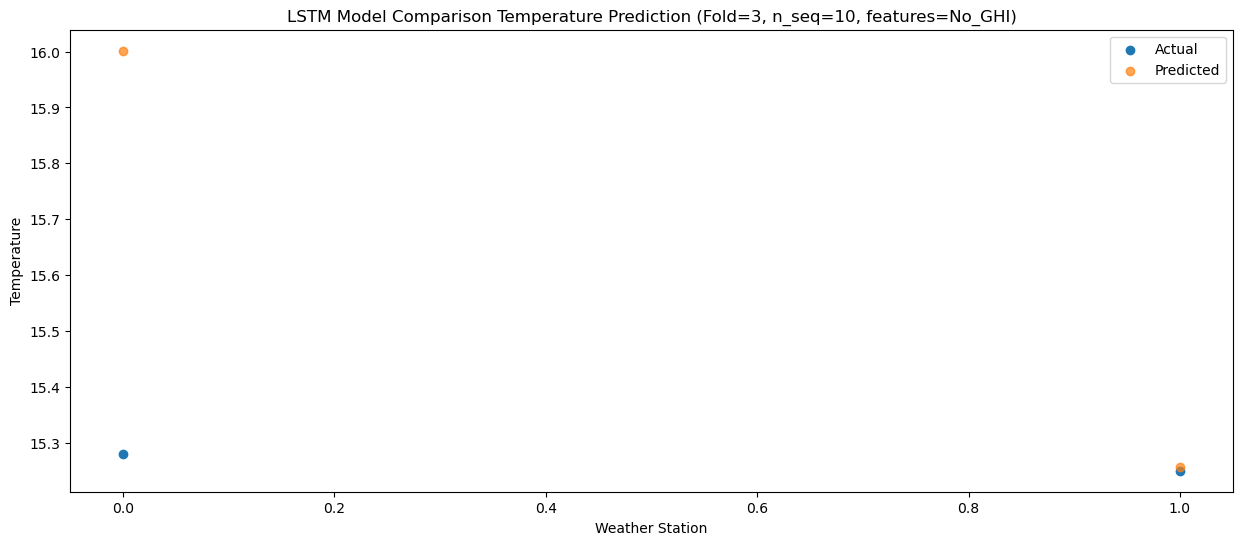

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   15.36  15.440657
1                1   14.76  14.706927


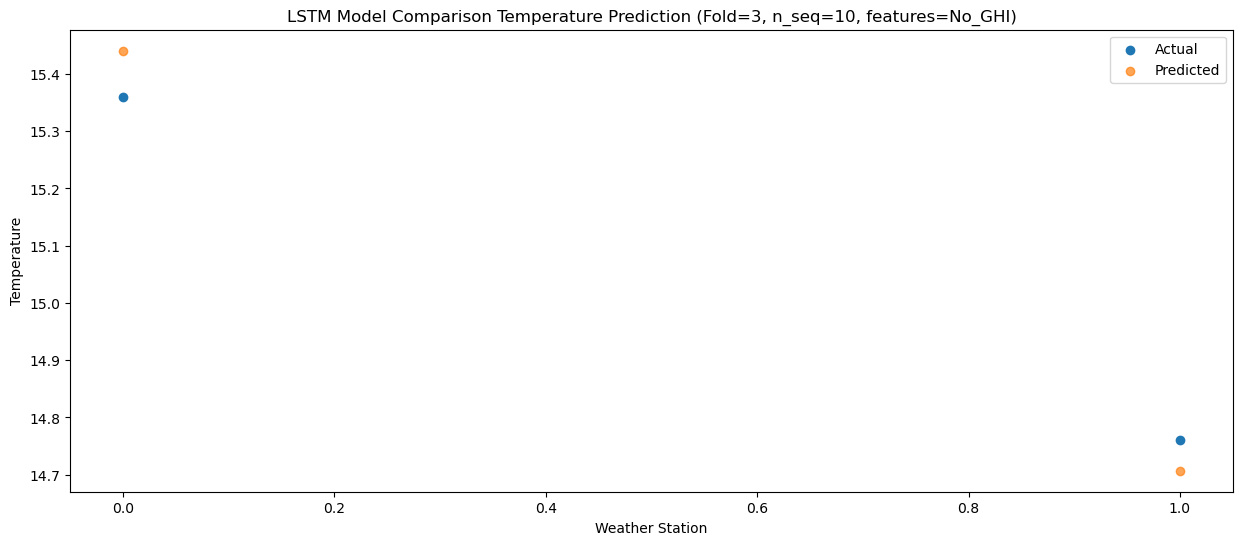

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   14.99  15.339162
1                1   15.17  14.622794


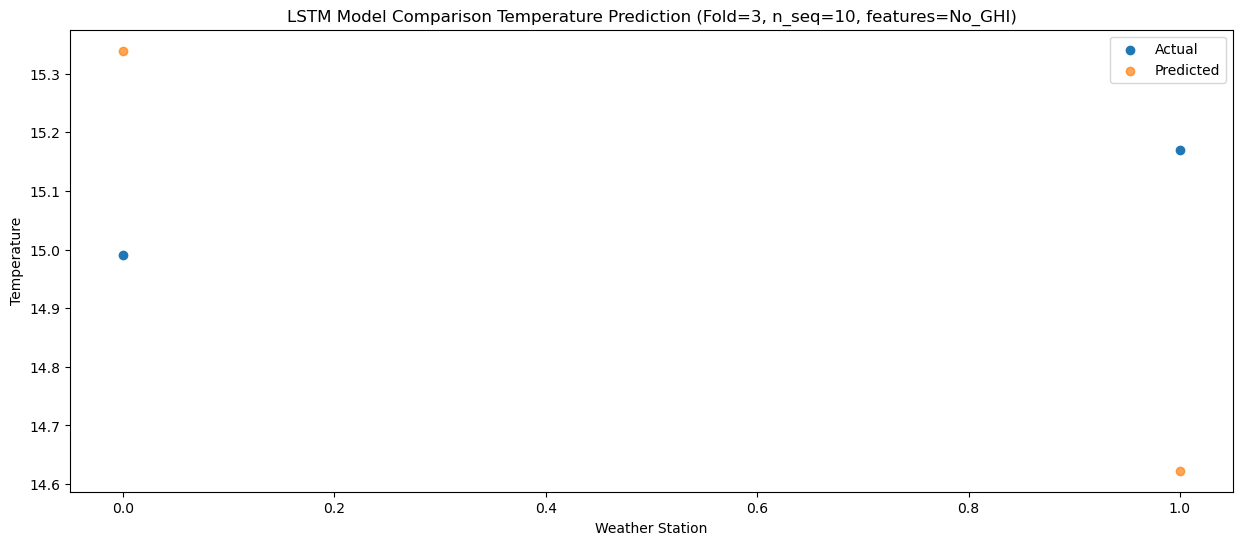

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   15.04  16.031460
1                1   15.05  15.291709


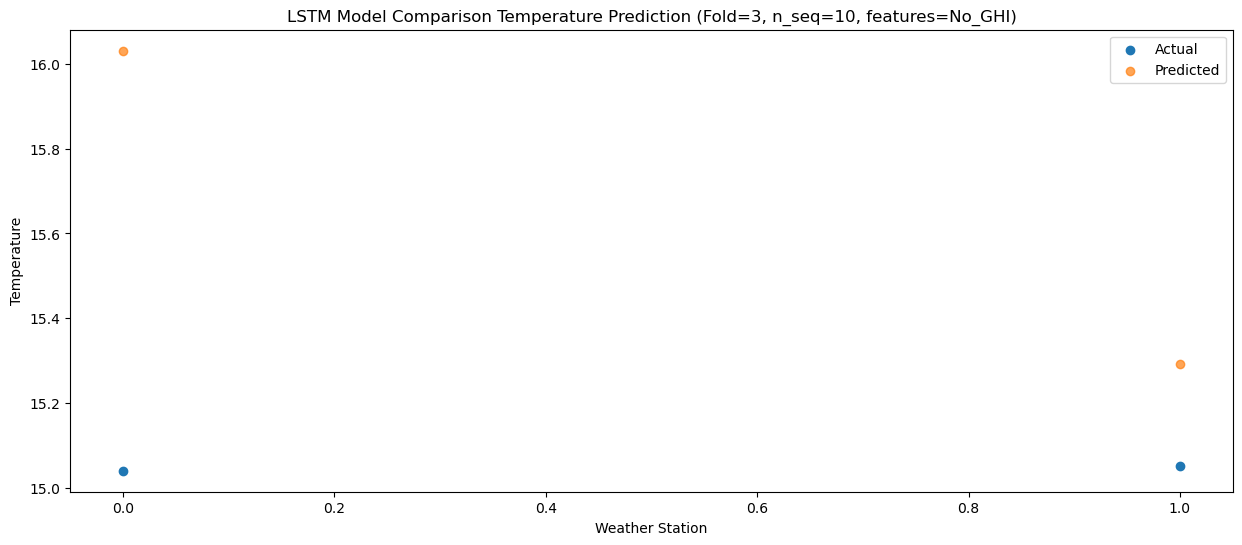

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   15.36  15.979144
1                1   14.85  15.241929


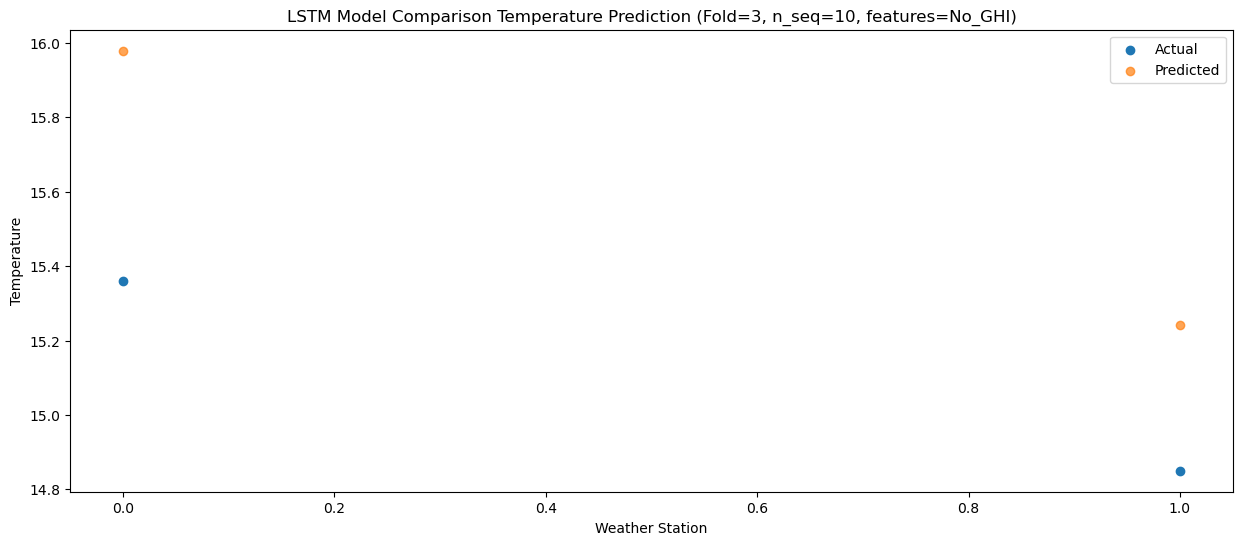

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   15.35  15.620116
1                1   14.55  14.889747


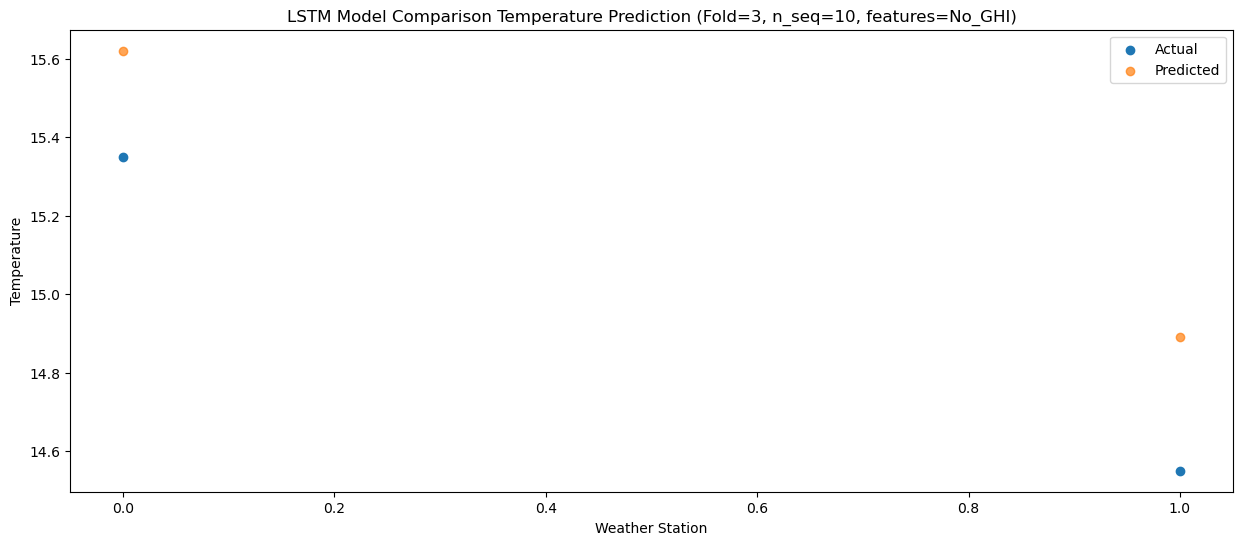

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   15.06  16.317624
1                1   15.57  15.609162


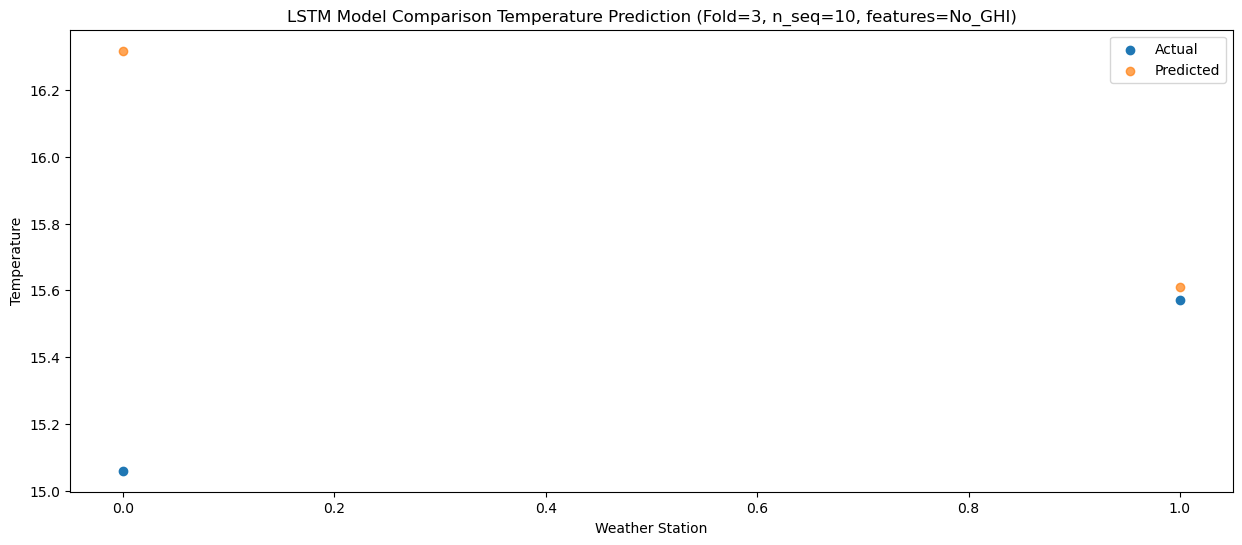

f, t:
[[16.17 13.03]
 [15.65 14.13]
 [15.35 15.42]
 [15.28 15.25]
 [15.36 14.76]
 [14.99 15.17]
 [15.04 15.05]
 [15.36 14.85]
 [15.35 14.55]
 [15.06 15.57]]
[[14.49678574 13.73073652]
 [15.44438628 14.70866534]
 [16.13889448 15.42050507]
 [16.00150023 15.25600521]
 [15.4406567  14.70692669]
 [15.33916211 14.62279362]
 [16.03146017 15.29170925]
 [15.97914366 15.24192878]
 [15.62011612 14.88974737]
 [16.31762362 15.60916155]]
Year at t+1:
t+1 SKRMSE: 1.282708
t+1 KRMSE: 1.282708
t+1 MAE: 1.186975
t+1 SKMAPE: 0.078628
t+1 R2_SCORE: 0.332493
t+1 KMAPE: 0.078628
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.434241
t+2 KRMSE: 0.434241
t+2 MAE: 0.392140
t+2 SKMAPE: 0.027046
t+2 R2_SCORE: 0.673537
t+2 KMAPE: 0.027046
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.557833
t+3 KRMSE: 0.557833
t+3 MAE: 0.394700
t+3 SKMAPE: 0.025713
t+3 R2_SCORE: -253.022347
t+3 KMAPE: 0.025713
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.510195
t+4 KRMSE: 0.510195
t+4 MAE: 0.363753
t+4 SKMAPE: 0.023806
t+

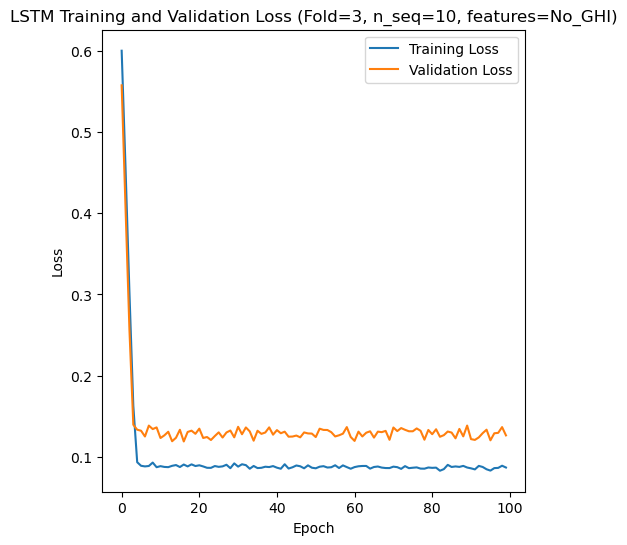

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 18s 257ms/step - loss: 0.5916 - accuracy: 0.0000e+00 - mae: 0.5802 - rmse: 0.5916 - mape: 91.7068 - pearson: 0.0662 - val_loss: 0.5404 - val_accuracy: 0.0000e+00 - val_mae: 0.5136 - val_rmse: 0.5404 - val_mape: 80.5282 - val_pearson: 0.0278
Epoch 2/100
19/19 [==============================] - 2s 82ms/step - loss: 0.4736 - accuracy: 0.1053 - mae: 0.4616 - rmse: 0.4736 - mape: 72.7625 - pearson: 0.1719 - val_loss: 0.4258 - val_accuracy: 0.0000e+00 - val_mae: 0.3927 - val_rmse: 0.4258 - val_mape: 60.2489 - val_pearson: 0.1130
Epoch 3/100
19/19 [==============================] - 1s 74ms/step - loss: 0.350

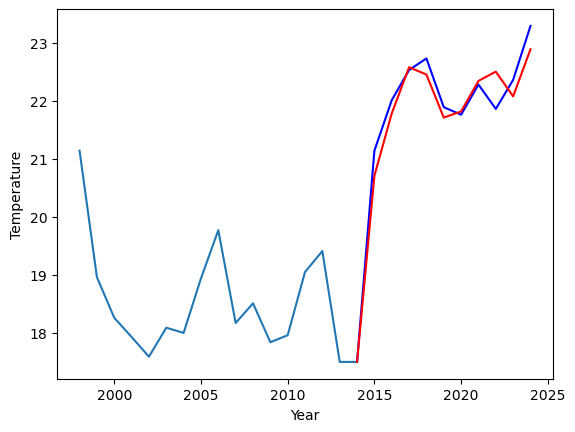

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.63		12.50		-0.13
14.58		13.57		-1.01
15.60		14.37		-1.23
15.53		14.22		-1.31
14.23		13.50		-0.73
13.53		13.61		0.08
14.09		14.12		0.03
14.41		14.28		-0.13
13.54		13.87		0.33
15.02		14.68		-0.34


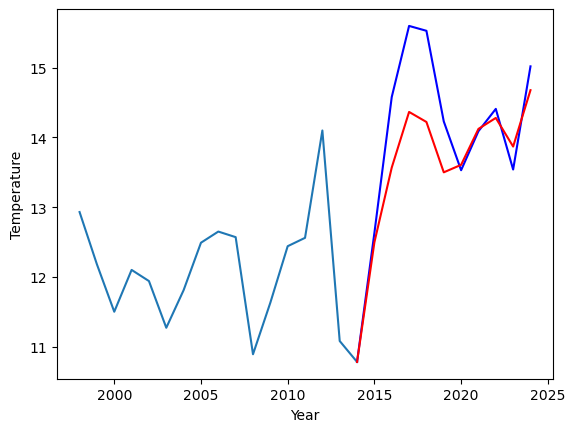

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.14  20.707625
1                1   12.63  12.496072


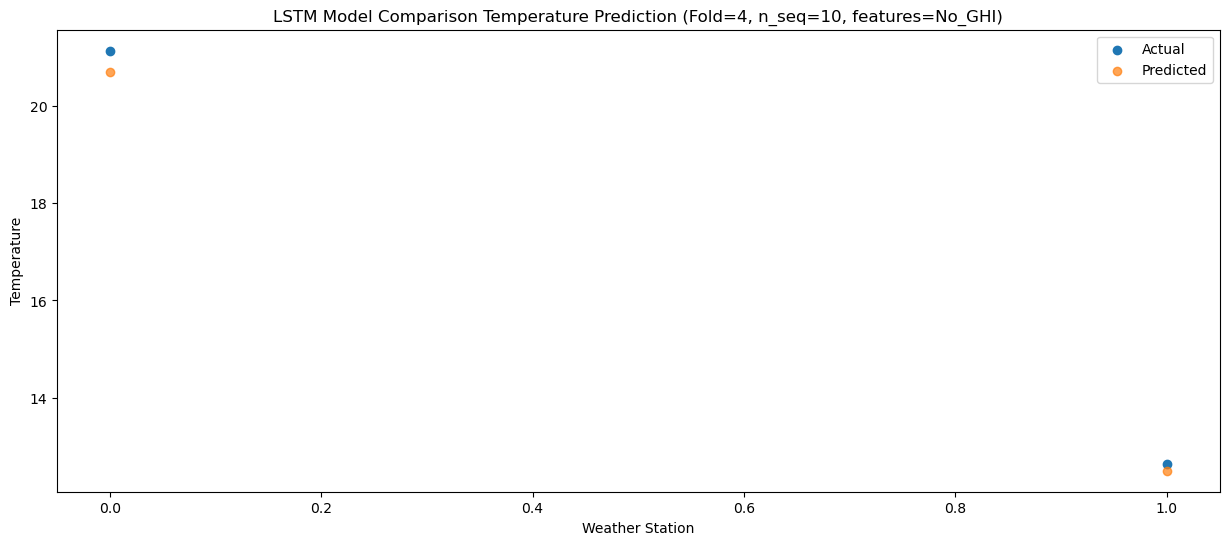

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   22.01  21.782210
1                1   14.58  13.568025


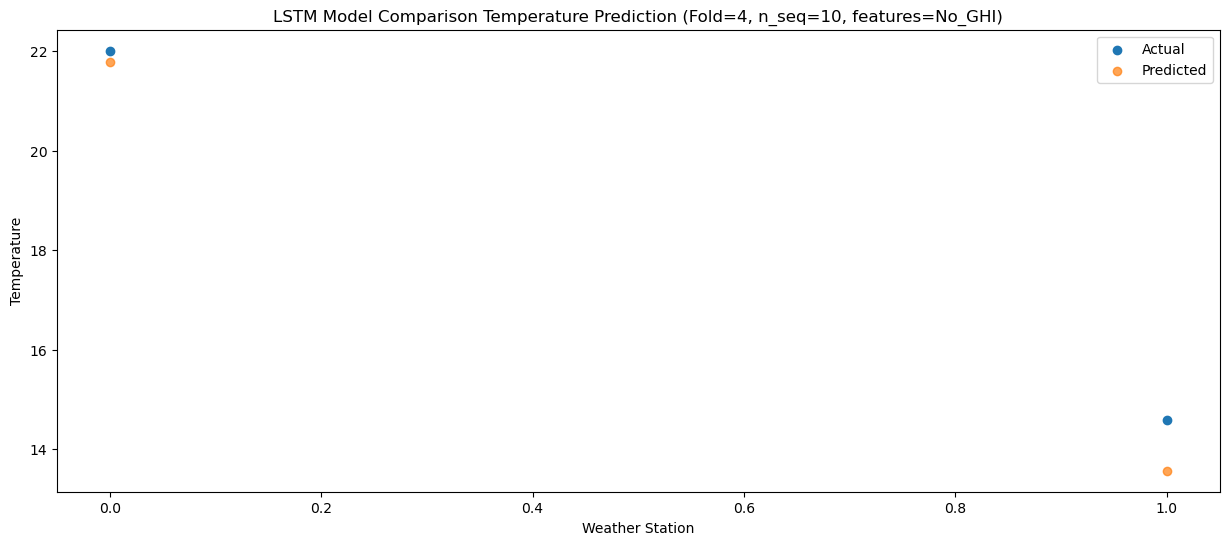

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.53  22.578566
1                1   15.60  14.366156


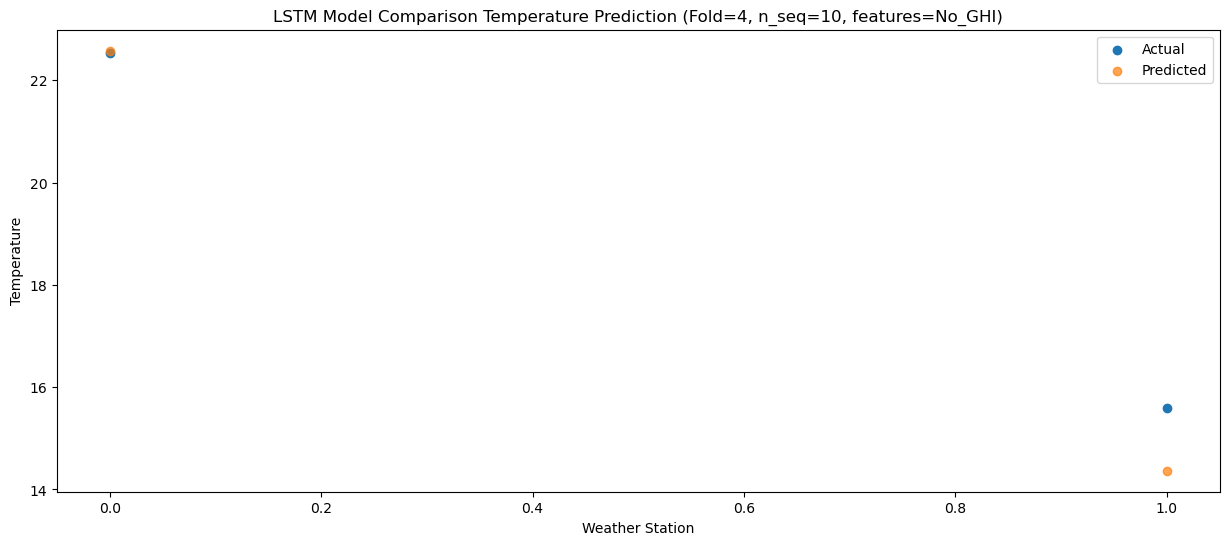

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.73  22.452175
1                1   15.53  14.222109


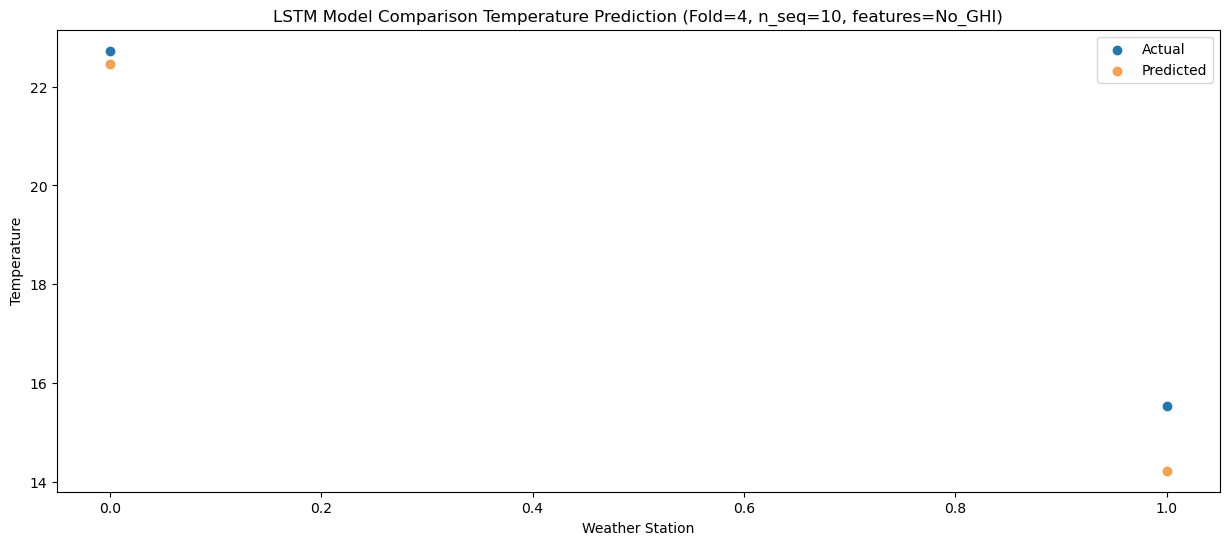

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.89  21.710993
1                1   14.23  13.499835


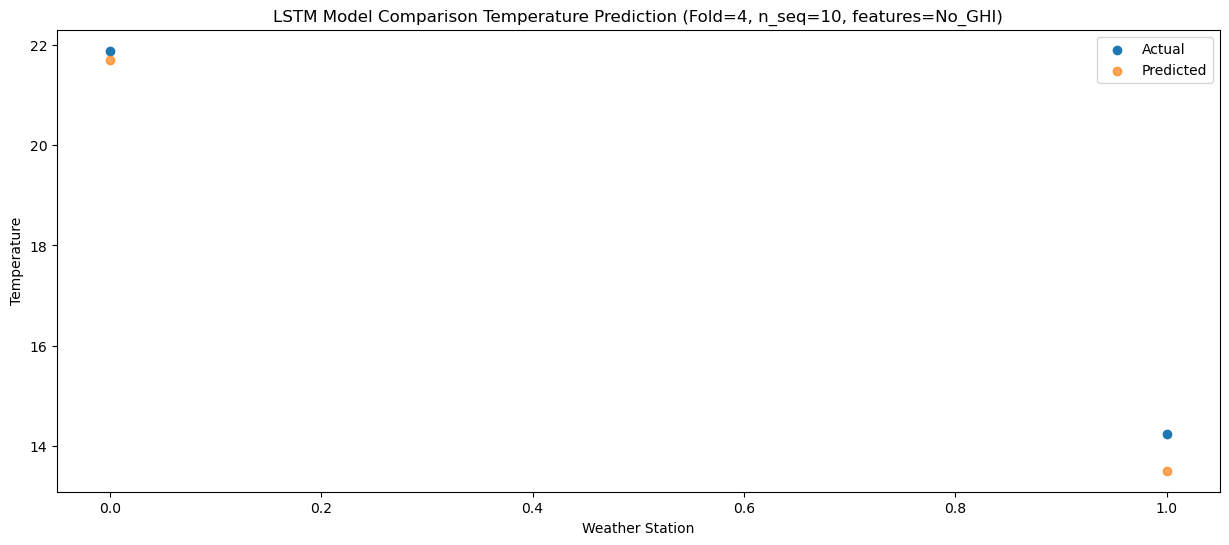

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.76  21.815739
1                1   13.53  13.607314


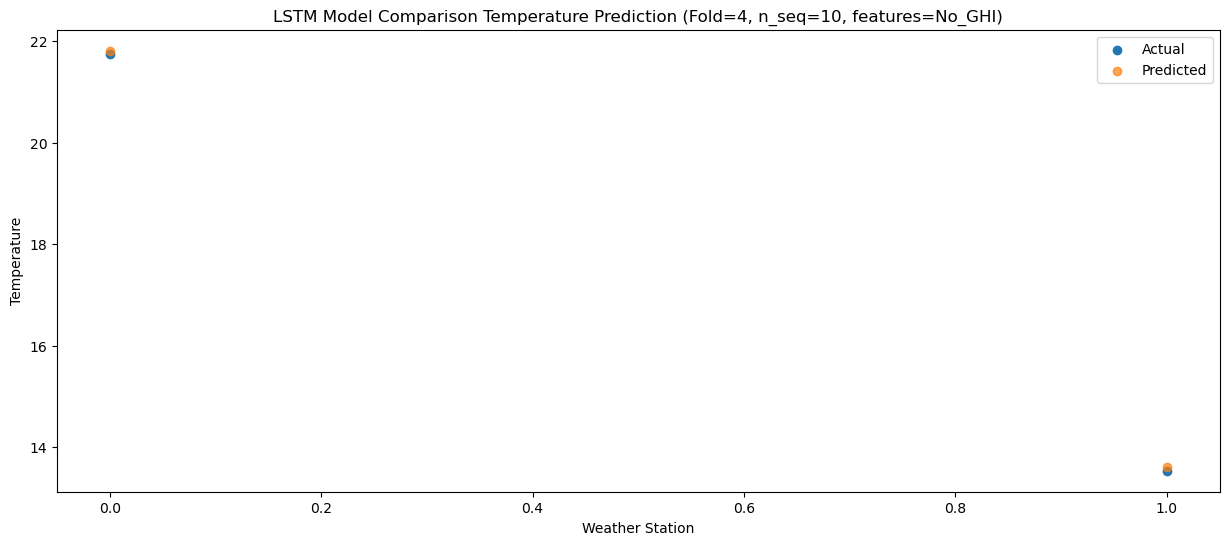

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   22.28  22.342267
1                1   14.09  14.122950


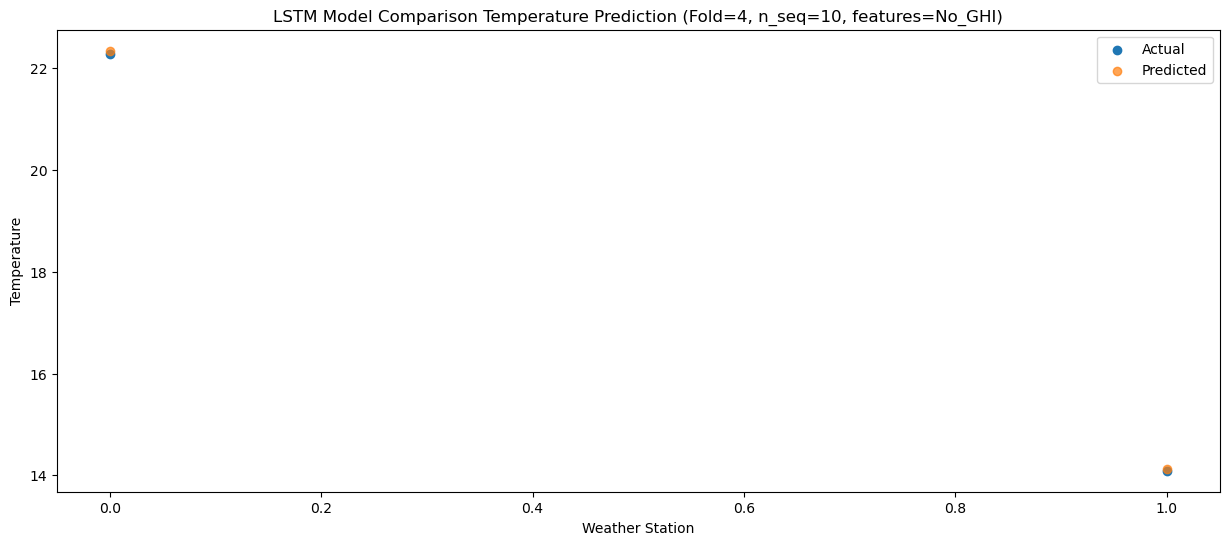

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.86  22.502079
1                1   14.41  14.280079


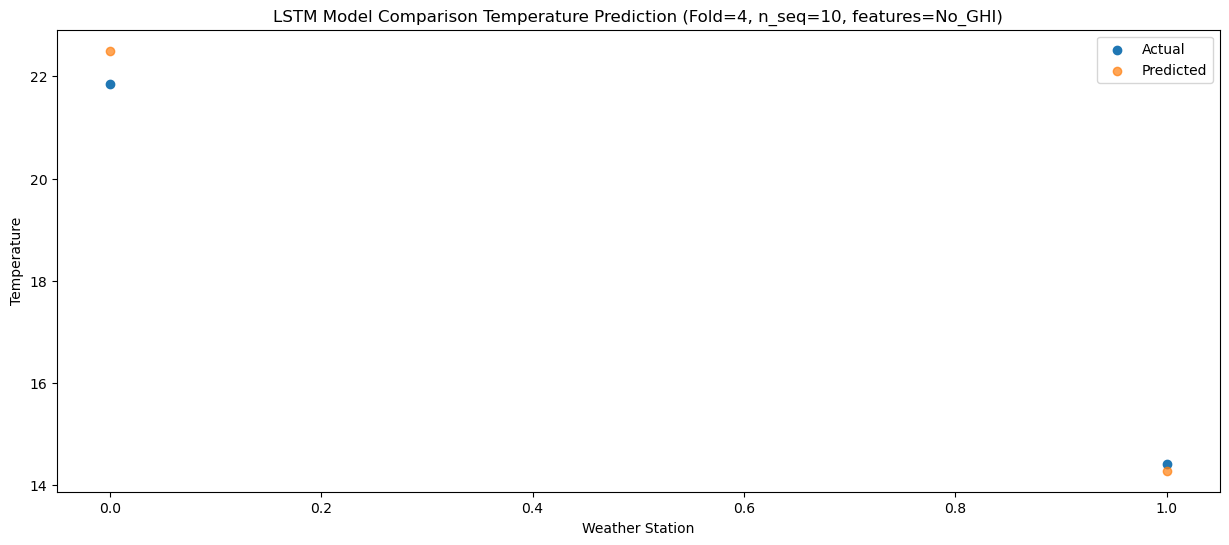

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   22.36  22.076088
1                1   13.54  13.869433


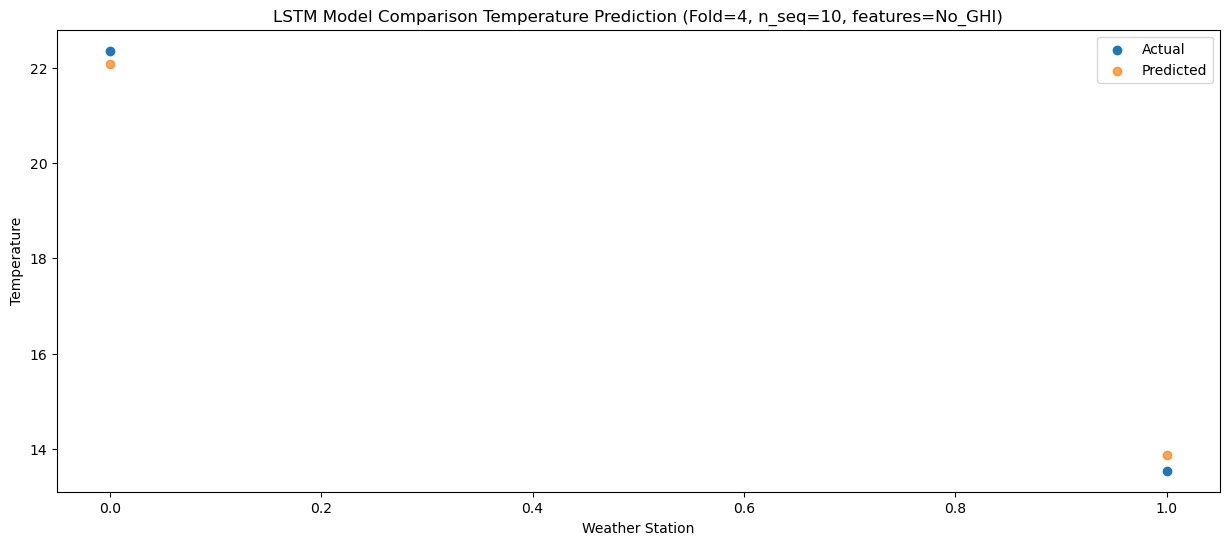

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   23.29  22.887244
1                1   15.02  14.678474


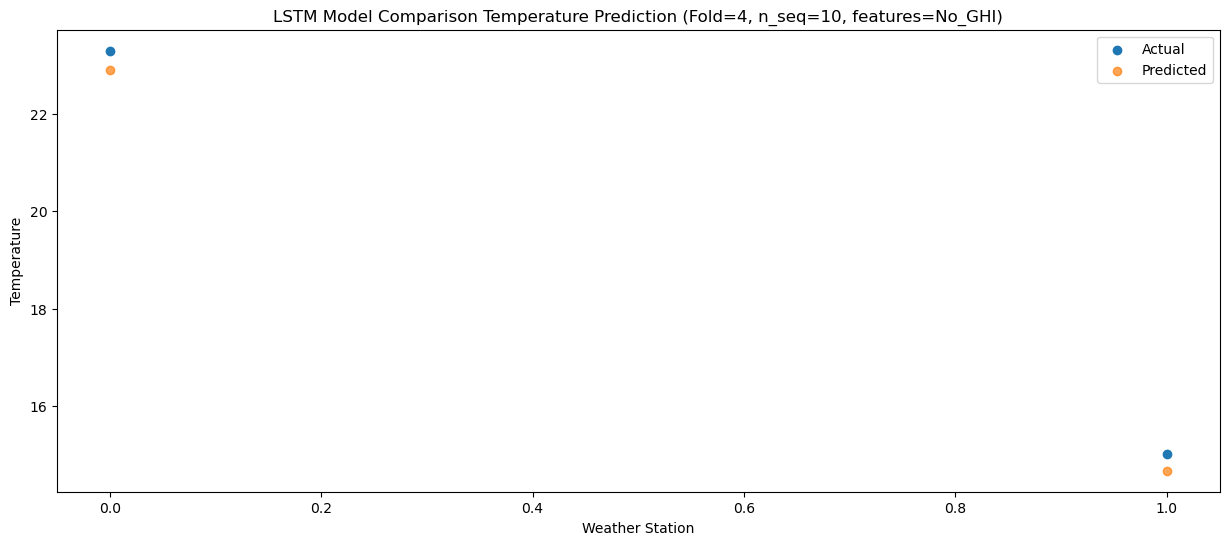

f, t:
[[21.14 12.63]
 [22.01 14.58]
 [22.53 15.6 ]
 [22.73 15.53]
 [21.89 14.23]
 [21.76 13.53]
 [22.28 14.09]
 [21.86 14.41]
 [22.36 13.54]
 [23.29 15.02]]
[[20.70762463 12.49607205]
 [21.7822103  13.5680251 ]
 [22.57856621 14.36615639]
 [22.45217492 14.22210931]
 [21.71099313 13.49983465]
 [21.81573888 13.60731378]
 [22.34226742 14.12294993]
 [22.50207948 14.28007853]
 [22.07608773 13.86943257]
 [22.88724395 14.67847389]]
Year at t+1:
t+1 SKRMSE: 0.320067
t+1 KRMSE: 0.320067
t+1 MAE: 0.283152
t+1 SKMAPE: 0.015528
t+1 R2_SCORE: 0.994342
t+1 KMAPE: 0.015528
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.733478
t+2 KRMSE: 0.733478
t+2 MAE: 0.619882
t+2 SKMAPE: 0.039879
t+2 R2_SCORE: 0.961019
t+2 KMAPE: 0.039879
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.873135
t+3 KRMSE: 0.873135
t+3 MAE: 0.641205
t+3 SKMAPE: 0.040624
t+3 R2_SCORE: 0.936503
t+3 KMAPE: 0.040624
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.945454
t+4 KRMSE: 0.945454
t+4 MAE: 0.792858
t+4 SKMAPE: 0.048220
t+4 R

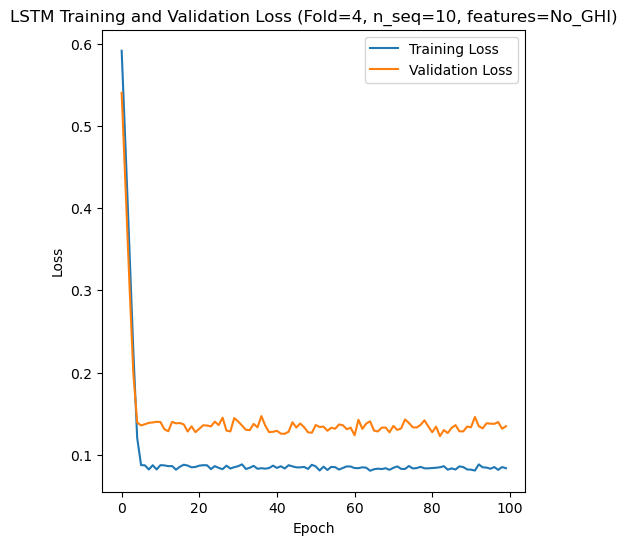

[[0.673697868221649], [0.47632032162832383], [0.5348790316997005], [0.6554135468166821], [0.5508957378686385]]
[[array(0.67369787)], [array(0.47632032)], [array(0.53487903)], [array(0.65541355)], [array(0.55089574)]]
[[0.4653527377992859], [0.3806627511978151], [0.39011101338267384], [0.49280619244277446], [0.3970631838738917]]
[[0.024088846520723007], [0.01889935285859757], [0.023441170504841208], [0.032712513732014385], [0.023842416118094335]]
[[0.8922603690445327], [-0.008109309665637054], [0.9240122223615728], [-0.10169445334095006], [0.9810673854900303]]
[[array(0.02408885)], [array(0.01889935)], [array(0.02344117)], [array(0.03271251)], [array(0.02384242)]]
[[array(0.93923064)], [array(0.29091491)], [array(0.95658177)], [array(0.2806203)], [array(0.9875022)]]
[[[20.515758063793182, 21.508265879154205, 22.194681313037872, 21.878532376289368, 21.16217848300934, 21.04800008624792, 21.58214156717062, 21.689591359496116, 21.243534665703773, 22.109837215542793], [16.256560302972794, 17

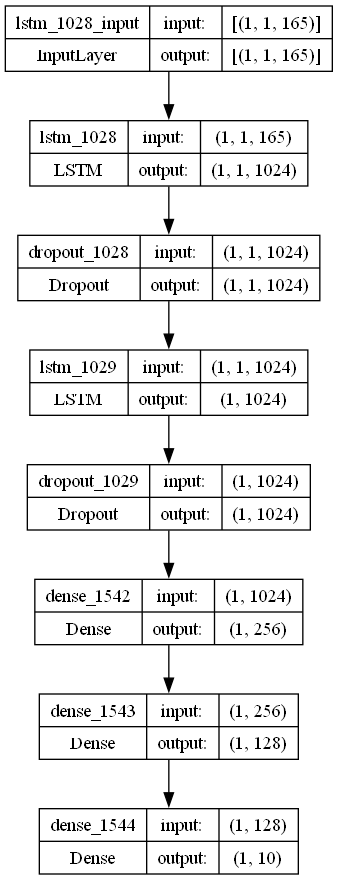

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.005489935837225713
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.12003441161825378

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S10_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)